# Droplet Bounce Parameter Estimation
## Import experimental data

In [1]:
import os, fnmatch, csv
import numpy as np

class Experiment(object):
    def __init__(self, data, name, start=0, end=-1, volume=1, surfaceV='[1000]', frame_rate=29.95, 
                 outlier=False, time=1, debias=1, layers=4, guess=0.72*2.3):
        self.data = data
        self.name = name
        self.start = start
        self.end = end
        self.volume = volume
        self.surfaceV = surfaceV #sum(surfaceV)/len(surfaceV)
        self.frame_rate = frame_rate
        self.outlier = outlier
        #self.charge = charge
        #self.u0 = u0
        self.time = time
        self.debias = debias
        self.layers = layers
        self.guess = guess

def print_header(drop):
    """
    Prints the drop name and measured experimental parameters.
    """
    print('name', drop.name)
    print('volume', drop.volume, 'mL')
    print('surfaceV', drop.surfaceV, 'V')
    
def import_data(exp_class):
    """
    Takes an experiment type and returns an array of Experiment class objects, with attributes specified by
    a metadata csv. The 'data' attribute The column heads include:
    'R','Area','XM','YM','Major','Minor','Angle','Circ','Slice','AR','Round','Solidity'
    """
    meta_file_location = '../data/' + exp_class + '/meta.csv'
    imported_datatype = ('U9', int, int, float, object, float, bool, float, float, int, int, float)
    metadata = np.genfromtxt(meta_file_location, delimiter=';', dtype=imported_datatype, names=True)
    for keys, vals in np.ndenumerate(metadata['surfaceV']):
        metadata['surfaceV'][keys] = np.fromstring(vals, dtype=float, sep=',')
    globals()[exp_class + '_data_list'] = np.array([])
    for drop in metadata:
        name = 'drop' + str(drop['name'])
        path = '../data/' + exp_class + '/' + str(drop['name']) + '.csv'
        data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)
        print(path[-8:])
        start = drop['start']
        end = drop['end']
        volume = drop['volume']
        surfaceV = drop['surfaceV']
        frame_rate = drop['frame_rate']
        outlier = drop['outlier']
        time = drop['time']
        debias = drop['debias']
        layers = drop['layers']
        guess = drop['guess']
        first_frame = drop['first_frame']
        data = data[first_frame:-1]
        data['Slice'] -= first_frame
        data['Minor'] = data['Minor']/2
        data['Major'] = data['Major']/2
        
        # check for gaps
        if (data.shape[0]) < data['Slice'][-1]:
            print('there is {} cells of gap'.format(int((data['Slice'][-1] - data.shape[0]))))
        globals()[str(name)] = Experiment(data, name, start, end, volume, surfaceV,
                                          frame_rate, outlier, time, debias, layers, guess)
        globals()[exp_class + '_data_list'] = np.append(globals()[exp_class + '_data_list'], 
                                                        globals()[str(name)])
    print('done!')

In [2]:
exp_class = 'dielectric_improved'
import_data(exp_class)

# use fancy indexing to make a list of outliers
mask = [datas.outlier==False for datas in globals()[exp_class + '_data_list']]
outliers = {datas.name:datas for datas in globals()[exp_class + '_data_list'][mask]}
alldrops = {datas.name:datas for datas in globals()[exp_class + '_data_list']}
alldrops = outliers

7294.csv
there is 2 cells of gap
7295.csv
there is 1 cells of gap
7296.csv
7297.csv
7298.csv
7299.csv
7300.csv
7301.csv
7319.csv
7325.csv
7326.csv
7327.csv
7328.csv
7329.csv
7334.csv
7335.csv
7336.csv
done!


## Filtering

In [3]:
from scipy import signal

def sg_filter(y, dt):
    """
    Takes raw data and returns a filtered array of the same length. 
    The function avoids IndexErrors by a simple rule for setting the window size.
    """
    #try:
    if y.shape[0]>25:
        window = 25
    else:
        window = y.shape[0]
        if window % 2 ==0:
            window-=3
    return derivs(y, window, dt)
    #except ValueError:
    #    print('debug: Window size', window)
        
def derivs(y, window, dt):
    """
    Returns Savitsky-Golay filtered array of a variable and its derivatives by finite differences.
    """
    dtdt=dt*dt
    y_savgol = signal.savgol_filter(y, window, 3, deriv=0, axis=0)
    y_savgol1 = signal.savgol_filter(y_savgol, window, 3, deriv=0, axis=0)
    y_savgol2 = signal.savgol_filter(y_savgol1, window, 3, deriv=0, axis=0)
    y_savgol3 = signal.savgol_filter(y_savgol2, window, 3, deriv=0, axis=0)
    dy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=1, axis=0)/dt
    ddy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=2, axis=0)/dtdt
    return y_savgol3, dy_savgol, ddy_savgol

##  Trajectory Plots

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import pylab
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

#matplotlib.use('pgf')
#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (10,10)

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'], # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": ['Computer Modern Sans serif'],
    "font.monospace": ['Computer Modern Typewriter'],
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "font.size": 12,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

#%config InlineBackend.figure_formats = ['svg']
#matplotlib.rcParams['text.latex.unicode'] = True
#matplotlib.rcParams.update(pgf_with_latex)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'
pics = True

In [5]:
def savefig(filename, pics):
    if pics == True:
        plt.savefig('../doc/figures/{}.pgf'.format(filename), bbox_inches='tight')
    else:
        pass

In [182]:
def plot_single(drop, args_for_components=['YM'], kwargs_for_plot={'color':'k'}, **kwargs):
    """
    Plots a given variable over the trajectory of a single drop.
    """
    #plt.xlabel('t ($s$)')
    if 'parted' in kwargs.keys() and kwargs['parted']==True:
        (ym, t, dt, contact_mask, y_parted, 
        dy_parted, ddy_parted, t_parted, ind_parted) = get_data(drop, param_est=False)
        component = {'y_parted': y_parted, 'dy_parted':dy_parted, 'ddy_parted':ddy_parted}
        if 'sub' in kwargs.keys():
            i = kwargs['i']
            fig = kwargs['fig']
            axs = kwargs['axs']
            axs[i].plot(t_parted, component[kwargs['variable']], 'ko', 
                    markersize=6, markerfacecolor='white', markeredgecolor='black', label='data')
            axs[i].plot(t_parted[ind_parted.flatten()], component[kwargs['variable']][ind_parted.flatten()], 'o')
            #axs[i].ylabel(kwargs['variable'])
            #axs[i].legend(title=drop.name)
        else:
            plt.plot(t_parted, component[kwargs['variable']], 'k.')
            plt.plot(t_parted[ind_parted.flatten()], component[kwargs['variable']][ind_parted.flatten()], 'o')
            plt.ylabel(kwargs['variable'])
    else:
        try:
            a = drop.start + kwargs['start']
        except KeyError:
            a = drop.start
        b = -drop.end
        t = drop.data['Slice'][a:b]/drop.frame_rate
        for component in args_for_components:
            y = drop.data[component][a:b]
            if 'n' in kwargs.keys():
                minm = signal.argrelextrema(y, np.less, order=4)[0][::]
                minm = np.append([0],minm)
                minm = np.append(minm, [len(y)-1])
                maxm = signal.argrelextrema(y, np.greater, order=4)[0][::]
                n=kwargs['n']
                if n == 'all':
                    plt.plot(t, y, label=drop.name, **kwargs_for_plot)
                    plt.plot(t[minm],y[minm],'o')
                    plt.plot(t[maxm],y[maxm],'o')
                    plt.ylabel(component)
                else:
                    plt.plot(t[minm[n]:minm[n+1]+1], y[minm[n]:minm[n+1]+1], label=drop.name, **kwargs_for_plot)
                    plt.plot(t[minm][n:n+2],y[minm][n:n+2],'o')
                    plt.plot(t[maxm][n],y[maxm][n],'+')
                    plt.ylabel(component)
            elif 'c' in kwargs_for_plot.keys():
                plt.plot(t,y, **kwargs_for_plot)
            elif 'points' in kwargs.keys():
                plt.plot(t,y,'k-')
            elif 'qm' in kwargs.keys() and kwargs['qm']==True:
                eu, t0, y0, im = kwargs['qmvals']
                if 'dimless' in kwargs.keys() and kwargs['dimless']==True:
                    plt.plot(t/t0, y/(100*y0)-radius(volume=drop.result.x[1])/y0,
                             label=drop.name, **kwargs_for_plot)
                else:
                    plt.plot(t, y,label=drop.name, **kwargs_for_plot)
            else:
                plt.plot(t, y,label=drop.name, **kwargs_for_plot)
        #return t[-1]
            if 'single' in kwargs.keys() and kwargs['single']==True:
                plt.show()
            else:
                pass

def plot_series(dataset, component='YM', **kwargs):
    """
    Plots a given variable over the trajectories of a series of drops.
    """
    if 'qm' in kwargs.keys() and kwargs['qm']==True:
        if 'reg' in kwargs.keys():
            if kwargs['reg'] == 'l':
                n=1
                m=1
            elif kwargs['reg'] == 'll':
                n=2
                m=1
            else:
                n=0
                m=0
        else:
            n = 0
            m = 0
        qs = np.array([])
        ts = np.array([])
        ys = np.array([])
        im = np.array([])
        #for drops in dataset.keys():
        for keys, vals in enumerate(dataset.items()):
            drop = vals[1]
            qs = np.append(qs, q_to_m(drop)[m])
            im = np.append(im, img(drop))
            ys = np.append(ys, yc(drop)[m])
            ts = np.append(ts, tc(drop)[n])
        norm = matplotlib.colors.LogNorm(vmin=(qs).min(), vmax=(qs).max())
        color = plt.get_cmap(kwargs['col'])
        my_map = cm.ScalarMappable(norm=norm, cmap=kwargs['col'])
        fig = plt.figure()
        for keys, vals in enumerate(dataset.items()):
            color = my_map.to_rgba(qs[keys])
            drop = vals[1]
            plot_single(drop, [component], kwargs_for_plot={'color':color}, 
                        qmvals=(qs[keys], ts[keys], ys[keys], im[keys]), **kwargs)
        my_map.set_array([])
        cb1 = plt.colorbar(my_map)
        cb1.set_label(r'${\mathbf{E} \mbox{u}}$', size=12, labelpad=14, rotation=0)
        plt.ylabel(kwargs['label'][1])
        plt.xlabel(kwargs['label'][0])
        if 'dimless' in kwargs.keys() and kwargs['dimless']==True:
            if 'reg' in kwargs.keys() and kwargs['reg']=='s':
                tn = get_data(drop, param_est=True)[0][-1]
                plt.xlim(xmax = 3, xmin=0)
                plt.ylim(ymin=0)
    else:
        total_time=[]
        vols = []
        for keys, vals in enumerate(dataset.items()):
            drop = vals[1]
            vols = np.append(vols, drop.volume)
        norm = matplotlib.colors.Normalize(vmin=0, vmax=len(vols))
        color = plt.get_cmap(kwargs['col'])
        my_map = cm.ScalarMappable(norm=norm, cmap=kwargs['col'])
        fig = plt.figure()
        for keys, vals in enumerate(dataset.items()):
            color = my_map.to_rgba(keys)
            drop = vals[1]
            tf = plot_single(drop, [component], kwargs_for_plot={'color':color}) #
            if drop.name in ['drop07298','drop07299','drop07297','drop07300']:
                total_time.append(tf)
            plt.legend(loc = 'upper right')
            plt.ylabel(component)
            plt.xlabel(r'$t$ (s)')

    #plt.xlim((0.1,2.2))
    if 'savefig' in kwargs.keys() and kwargs['savefig']==True:
        name = kwargs['name']
        savefig(name, pics)
    plt.show()

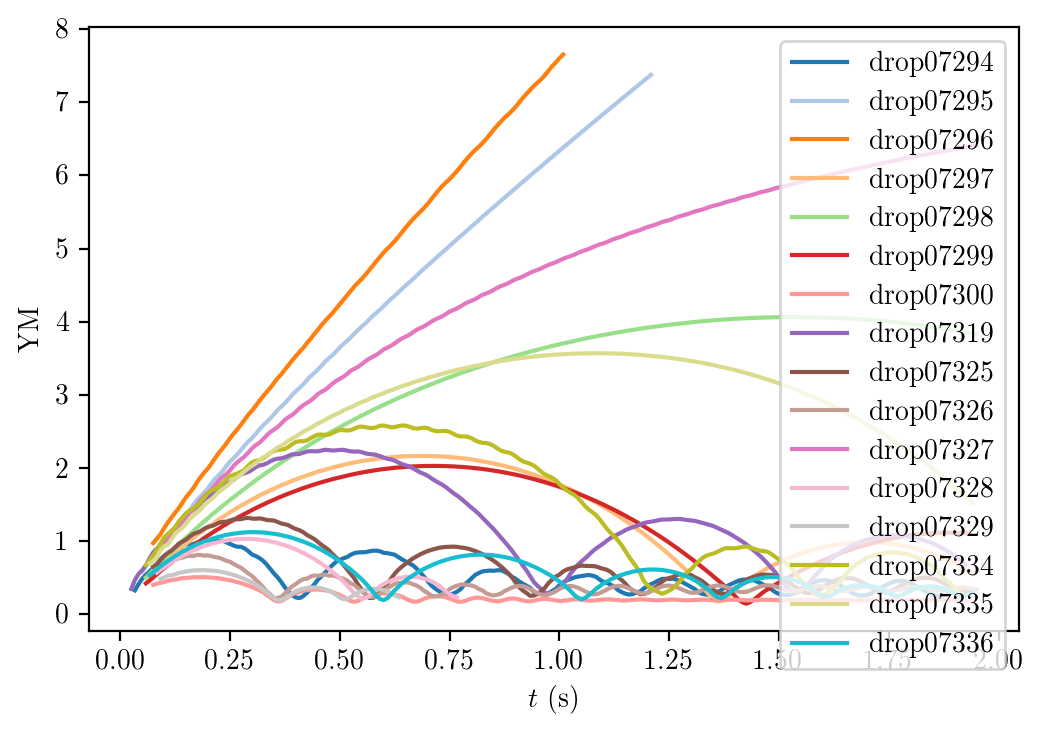

name drop07334
volume 0.5 mL
surfaceV [ 1600.   900.] V


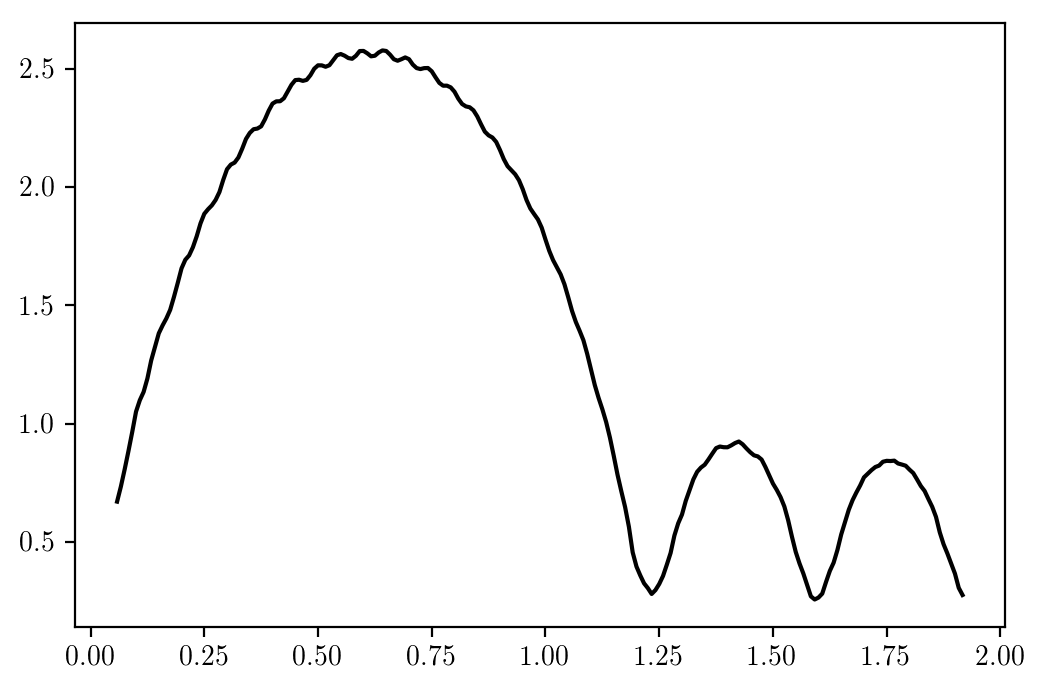

In [7]:
"""
Use n=1,2,3 etc (where n may be 0 or any positive integer)  to look at an individual bounce.
Otherwise use n='all' to see all bounces.
"""

drop = drop07334
#drop.start=10
#print(len(get_data(drop, param_est=False)[1]), get_data(drop, param_est=False)[1][0], drop.start, drop.end)
plot_series(alldrops, component='YM', qm=False, savefig=False, col='tab20')
print_header(drop)
plot_single(drop, parted=False, variable='y_parted', points=True, single=True)

In [8]:
# #A bash program to write experiemental metadata.

#header = {'name':1,'start':2,'end':3,'volume':4,'surfaceV':5, \
#          'frame_rate':6,'outlier':7,'time':8,'debias':9,'first_frame':10}
#row = !grep -n "{drop.name[4:]}" ../data/dielectric_improved/meta.csv | cut -d , -f 1 | cut -d : -f 1
#row = int(row[0])
#col = header['start']
#value = drop.start

In [9]:
%%bash -s "$row" "$col" "$value"
#awk -F ";" -v r=$1 -v c=$2 -v val=$3 'BEGIN{OFS=";"}; NR != r; NR == r {$c = val; print}' \
#../data/dielectric_improved/meta.csv > ../data/dielectric_improved/meta2.csv
#cp ../data/dielectric_improved/meta2.csv ../data/dielectric_improved/meta.csv
#rm ../data/dielectric_improved/meta2.csv
cat ../data/dielectric_improved/meta.csv

name;start;end;volume;surfaceV;frame_rate;outlier;time;debias;first_frame;layers;guess
07294;3;1;0.4;1600,300;120;False;239;1200;3;4;2.76
07295;4;1;0.2;800,700;120;False;99;300;2;4;1.4949999999999999
07296;8;1;0.2;500,800;120;False;41;200;2;4;1.4949999999999999
07297;7;1;0.1;700,600;120;False;285;0;1;4;2.9899999999999998
07298;6;1;0.08;600,600;120;False;108;0;2;4;2.76
07299;6;1;0.05;600,500;120;False;83;0;2;4;3.4499999999999997
07300;8;1;0.03;500,500;120;False;90;0;2;4;4.83
07301;6;1;0.03;200,300;120;True;151;500;1;4;7.13
07319;2;1;0.3;1400,1400;120;False;999;0;1;4;1.38
07325;8;1;0.2;1300,1000;120;False;999;400;1;3;1.9549999999999998
07326;7;1;0.15;1000,1100;120;False;999;0;1;3;2.484
07327;10;1;0.3;1000,800;120;False;999;0;1;3;1.4167999999999998
07328;9;1;0.1;800,800;120;False;999;0;1;3;2.8979999999999997
07329;10;1;0.1;700,700;120;False;999;0;1;3;3.0589999999999997
07334;6;1;0.5;1600,900;120;False;999;500;1;3;1.4076000000000002
07335;7;1;0.2;800,800;120;False;999;0;1;3;2.05275
07336;7

##  Munging

In [10]:
def radius(**kwargs):
    """
    Given experimental volume (in mL) the functon returns droplet radius (in m).
    """
    if 'mass' in kwargs.keys():
        pass
    if 'volume' in kwargs.keys():
        vol = kwargs['volume']
        return (3 * vol * 1E-6/(np.pi * 4))**(1/3.) # droplet radius [m]

def mass(volume):
    """
    Given experiemental volume (in mL) the function returns mass (in kg).
    """
    return 1000 * volume * 1E-6

def volume(radius_drop):
    """
    Given the radius (in m) returns the volume (in m^3).
    """
    return 4/3*np.pi*radius_drop**3

def weber(drop, U):
    """
    Returns the Weber number.
    """
    surface_tension = 72.86/1000
    density = 1000
    return density*2*radius(volume=drop.volume)*(U/100)**2/surface_tension

def tj(drop):
    """
    Returns the dimensionless contact time.
    """
    surface_tension = 72.86/1000
    density = 1000
    return np.sqrt(density*radius(volume=drop.volume)**3/surface_tension)

def reynolds(U, R_drop):
    """
    Returns the Reynolds number.
    """
    nu = 15.11E-6
    D = 2 * R_drop
    return D*np.abs(U)/nu

def ohnesorge(drop):
    R_drop = radius(volume=drop.result.x[1])
    viscosity = 1.0016
    density = 1000
    surface_tension = 72.86/1000
    return viscosity/np.sqrt(density * surface_tension * R_drop)

def bond(drop):
    #surfaceV, volume, q, dy0
    R_drop = radius(volume=drop.result.x[1])
    surface_tension = 72.86/1000
    #e_force = charge_density(drop.result[0])*eta_0*drop.result[2]
    #e_force = eta_0 * 90 * drop.result[0]**2 #Ree0U^2/y
    e_force = drop.Ef0**2 * 80 * eta_0
    return e_force * R_drop / surface_tension

In [11]:
def ellipse(data):
    """
    Returns the droplet radius in the vertical direction.
    """
    YM = data['YM']
    a = data['Major']
    b = data['Minor']
    Angle = (data['Angle']-90)*np.pi/180
    return a*b/((b*np.cos(Angle))**2 + (a*np.sin(Angle))**2)**(1/2)

def ym_0(drop, n):
    """
    Returns drop minima and maxima.
    """
    ym = drop.data['YM'][drop.start:-drop.end]
    minm = signal.argrelextrema(ym, np.less, order=4)[0][::]
    maxm = signal.argrelextrema(ym, np.greater, order=4)[0][::]
    minm = np.append([0],minm)
    minm = np.append(minm, [len(ym)-1])
    intstart = minm[n]
    intend = minm[n+1]
    #if minm.shape[0] == 2:
    #    YM_0 = 0
    #else:
    #    YM_0 = ym[minm[1]] - ellipse(drop.data)[minm[1]]
    YM_0 = 0
    return YM_0, intstart, intend, minm

def contact(drop, ym, a, b):
    """
    Returns a mask with elements true where the droplet is not in contact with the surface.
    """
    contact = ym - ellipse(drop.data[a:b])*1 # distance from the bottom of the drop to YM_0
    atol = np.std(ellipse(drop.data[a:b]))*3
    above_mask = np.invert(np.isclose(contact, 0, atol=atol))
    below_zero_mask = np.invert(np.array([(contact <= 0)]))
    return np.logical_and(above_mask, below_zero_mask).flatten()

def get_data(drop, param_est=False, **kwargs):
    """
    Returns filtered droplet position, velocity and acceleration, up to the first trajectory apoapse when
    param_est==True, for all non-contacting time otherwise.
    """
    a = drop.start
    b = -drop.end
    t = drop.data['Slice'][a:b]/drop.frame_rate
    ym = drop.data['YM'][a:b]
    dt = t[1]-t[0]
    YM_0, intstart, intend, minm = ym_0(drop, n=0)
    ym = ym - YM_0
    contact_mask = contact(drop, ym, a, b)
    if param_est==True:
        intendmask = np.array([(t <= t[intend])])
        intstartmask = np.array([(t >= t[intstart])])
        parted_mask = np.logical_and.reduce((intstartmask.flatten(), intendmask.flatten(), contact_mask))
        try:
            maxm = signal.argrelextrema(sg_filter(ym[parted_mask],dt)[0], np.greater, order=4)[0][::][0]
        except IndexError:
            maxm = -1
        return (t[parted_mask][0:maxm], sg_filter(ym[parted_mask], dt)[0][0:maxm]/100, 
                sg_filter(ym[parted_mask], dt)[1][0:maxm]/100, sg_filter(ym[parted_mask], dt)[2][0:maxm]/100)
    else: #partitioning
        stepsize = 1
        #split_array = np.split(contact_mask, np.where(contact_mask[1:] != contact_mask[:-1])[0] + 1)
        #contact_array = [subarray for subarray in split_array if np.any(subarray)==False]
        #for keys, vals in enumerate(contact_array):
        #    vals = len(vals)/120
        #    contact_array[keys]=vals
        #
        indices = np.where(contact_mask[1:] != contact_mask[:-1])[0] + 1
        indices[::2]-=1
        if contact_mask[0]==True:
            indices = np.append(0,indices)
        if contact_mask[-1]==True:
            indices = np.append(indices, len(contact_mask)-1)
        y_parted = np.array([])
        dy_parted = np.array([])
        ddy_parted = np.array([])
        t_parted = np.array([])
        ind_parted = np.array([])
        for keys, vals in np.ndenumerate(indices):
            if keys[0] % 2 == 0 and indices[keys[0]+1]+1-vals>=10:
                ind_parted_a = len(y_parted)
                y_parted = np.append(y_parted, sg_filter(ym[vals:indices[keys[0]+1]+1], dt)[0])
                dy_parted = np.append(dy_parted, sg_filter(ym[vals:indices[keys[0]+1]+1], dt)[1])
                ddy_parted = np.append(ddy_parted, sg_filter(ym[vals:indices[keys[0]+1]+1], dt)[2])
                t_parted = np.append(t_parted, t[vals:indices[keys[0]+1]+1])
                ind_parted = np.append(ind_parted, [ind_parted_a, len(y_parted)-1])
        return ym, t, dt, contact_mask, y_parted, dy_parted, ddy_parted, t_parted, ind_parted.astype(int)

# Parameter Estimation

In [12]:
#inputs
d = 6.47/100

#physical constants
eta_0 = 8.85E-12       # vacuum permitivity
eta_r = 3.4            # relative permitivity
k = 1/(4*np.pi*eta_0)  # Coulomb's constant
global k, eta_0, d

In [13]:
def electric_field(end, sigma):
    """
    Returns the 1-D electric field, and the gradient of its square
    in the z-direction of a uniform finite square of charge.
    """
    
    #d = 6.5/100
    Ef = np.array([4*k*sigma*np.arctan(d**2/(2*z*np.sqrt(2*d**2 + 4*z**2))) \
                   for z in np.linspace(1E-6, end, 10000)])
    del_Ef2 = np.gradient(Ef**2)
    return Ef, del_Ef2

def ef2(z, sigma):
    return 4*k*sigma*np.arctan(d**2/(2*z*np.sqrt(2*d**2 + 4*z**2)))
        
def charge_density(surfaceV, layers):
    old = surfaceV * eta_0 * eta_r/((layers*2.8+5.9)/1000)
    return old

In [14]:
#
#print(np.mean(list(drop.surfaceV)))
#print('Actual fieldmeter reading -{:.2f} kV'.format(V))
#print('Simulated fieldmeter reading -{:.2f} kV'.format(electric_field(2.54/100, sigma)[2]/1000))
#print('Simulated fieldmeter reading -{:.2f} kV/m'.format(electric_field(2.54/100, sigma)[0]/1000))
#
## Plot the results
##from matplotlib import rc
##import pylab
##%config InlineBackend.figure_formats=['svg']
##%matplotlib inline
##rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
##rc('text', usetex=True)
#
#zz = np.linspace(0.00001, 3./100, 1000)              
##zz = np.linspace(0, 4, 1000)
#plt.semilogx(zz*1000, electric_field(zz, sigma)[2]/1000)
#plt.xlabel('z ($cm$)')
#plt.ylabel('Scalar Potential ($kV$)')
##plt.autoscale(enable=True, axis='x', tight=True)
#plt.yticks([2,3,4])
#plt.show()
#
#fig, ax1 = plt.subplots()
#ax1.plot(zz*100, electric_field(zz, sigma)[0]/1000, zz*100, electric_field(zz, sigma)[3]/1000)
#ax2 = ax1.twinx()
#ax2.plot(zz*100, np.multiply(electric_field(zz, sigma)[3],zz)/1000, 'r')
#ax1.set_xlabel('z ($cm$)')
#ax1.set_ylabel('Electric field ($kV/m$)')
#ax2.set_ylabel('Surface Voltage E*d ($kV$)')
#plt.show()
#
#fig, ax1 = plt.subplots()
#ax1.semilogy(zz*100, np.abs(electric_field(zz, sigma)[1]/1000), 'r', label=r'$\nabla E$')
#ax2 = ax1.twinx()
#ax2.semilogy(zz*100, np.abs(electric_field(zz, sigma)[4]/1000), 'k', label=r'$\nabla E^2$')
#ax1.set_xlabel('z ($cm$)')
#ax1.set_ylabel(r'$\nabla E$')
#ax2.set_ylabel(r'$\nabla E^2$')
#ax1.legend()
#plt.show()

In [15]:
def force_ep(q, Ef):
    """
    Returns the electrophoretic force [N], including the contribution to the 
    attraction of image charges reflected across the dielectric boundary.
    """
    return q * Ef

def force_image(z, q, R_drop):
    eta_a=eta_r
    susceptibility = eta_a - 1
    if z.any() <= 0:
        z[z <= 0] = R_drop
    return 1/(16*np.pi*eta_0)*susceptibility*q**2/z**2

def force_dep(z, R_drop, del_Ef):
    """
    Returns the dielectrophoretic force [N].
    """
    eta_air = 1.
    eta_water = 90.
    K = (eta_water - eta_air)/(eta_water + 2 * eta_air)
    return -2 * np.pi * R_drop**3. * eta_air * K * eta_0 * del_Ef

def cd(re):
    """
    Drag coefficent, Abraham correlation.
    """
    return 24/9.06**2 * (1 + 9.06/np.sqrt(re))**2
    
def drag(v, R_drop):
    """
    Returns the aerodynamic drag force [N].
    """
    rho = 1.225
    #Cd = 24/reynolds(v, R_drop) + 5/np.sqrt(reynolds(v, R_drop)) + 0.3
    return cd(reynolds(v, R_drop))*2*rho*np.pi*R_drop**2*v**2


In [16]:
import scipy.integrate as integrate
from scipy import stats

def f(y, t, params):
    """
    1-D Equation of motion for a droplet with initial velocity u0 subject to drag, and electrical forces.
    """
    
    z, u = y      # unpack current values of y
    m, R_drop, sigma, q, Ef, del_Ef, zf = params # unpack parameters 
    ef_interp = np.interp(z, zf, Ef)
    del_ef_interp = np.interp(z,zf,del_Ef)
    #- force_dep(z, R_drop, del_ef_interp)
    derivs = [u, (- force_ep(q, ef_interp) \
                  - force_image(z, q, R_drop) - drag(u, R_drop))/m] # list of dy/dt=f functions
    return derivs

def get_model(x, model_params):
    """
    Solves the ODE for the droplet trajectory given the design vector, x.
    """
    t0, z0, volt0, vol0, tStop, layers, q0, Ef, del_Ef, zf = model_params
    surfaceV, volume, q, u0 = x  
    m = mass(volume)                                # droplet mass [kg]
    R_drop = radius(volume=volume)                  # droplet radius
    sigma = charge_density(surfaceV, layers)
    
    # Initial values
    z0 = z0    # initial displacement
    u0 = u0    # initial velocity
    t0 = t0    # initial time

    # Bundle parameters for ODE solver
    params = (m, R_drop, sigma, q, Ef, del_Ef, zf)
    
    # Bundle initial conditions for ODE solver
    y0 = [z0, u0]

    # Make time array for solution
    tInc = 0.00001
    t_rk = np.arange(t0, tStop, tInc)

    # Call the ODE solver
    psoln = integrate.odeint(f, y0, t_rk, args=(params,), mxords=5)
    return psoln, t_rk

In [17]:
# error estimates from pyfssa
# http://pyfssa.readthedocs.io/en/stable/nelder-mead.html

def _neldermead_errors(sim, fsim, func, X0, *args):
    # fit quadratic coefficients
    fun = func
    args = args
    n = len(sim) - 1
    x = .5 * (sim[np.mgrid[0:n+1, 0:n+1]][1] + sim[np.mgrid[0:n+1, 0:n+1]][0])

    for i in range(n + 1):
        assert(np.array_equal(x[i,i], sim[i]))
        for j in range(n + 1):
            assert(np.array_equal(x[i,j], 0.5 * (sim[i] + sim[j])))

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(np.multiply(X0, x[i, j]), *args)

    y0i = y[np.mgrid[0:n+1, 0:n+1]][0][1:,1:, 0]
    for i in range(n):
        for j in range(n):
            assert y0i[i, j] == y[0, i + 1], (i, j)

    y0j = y[np.mgrid[0:n+1, 0:n+1]][0][0, 1:, 1:]
    for i in range(n):
        for j in range(n):
            assert y0j[i, j] == y[0, j + 1], (i, j)

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)
    for i in range(n):
        assert abs(b[i, i] - 2 * (fsim[i + 1] + fsim[0] - 2 * y[0, i + 1])) < 1e-12
        for j in range(n):
            if i == j:
                continue
            assert abs(b[i, j] - 2 * (y[i + 1, j + 1] + fsim[0] - y[0, i + 1] -
                y[0, j + 1])) < 1e-12

    q = (sim - sim[0])[1:].T
    for i in range(n):
        assert np.array_equal(q[:, i], sim[i + 1] - sim[0])
    
    varco = -np.dot(q, np.dot(np.linalg.inv(b), q.T)) # variance-covariance matrix
    #print(varco)
    w = np.abs(np.linalg.eig(varco)[0])
    cond = np.log10(np.nanmax(w)/np.nanmin(w))
    #print('condition number', cond)
    return np.sqrt(np.diag(varco))

In [18]:
import scipy.optimize as opt
import scipy.interpolate as interp

def get_params(drop, a=3.5, **kwargs):
    """
    Gets experimental parameters from drop object.
    """
    layers = drop.layers
    surfaceV = np.mean(drop.surfaceV)              # superhydrophobic surface potential
    volume = drop.volume                           # droplet volume
    if hasattr(drop, 'guess'):
        q = drop.guess*1E-12*volume*surfaceV
    else:
        q = a*1E-12*volume*surfaceV                # wild-ass guess droplet net charge [C]
    if 'test' in kwargs.keys() and kwargs['test']==True:
        q = a*1E-12*volume*surfaceV
    sigma = charge_density(surfaceV, layers)
    t, y, dy, ddy = get_data(drop, param_est=True)
    t0 = t[0]                                       # droplet initial time
    y0 = y[0]                                       # droplet initial position
    dy0 = dy[0]                                     # droplet initial y-velocity
    return surfaceV, volume, q, sigma, t0, y0, dy0, layers  #remove sigma, m, R_drop

def get_constraints(drop):
    """
    Gets the minimization problem constraints from the experimental measurement error for each parameter.
    """
    
    constraints = {'volume': 0.02,      # [m^3]
                    'q': None,
                    't0': 1/120.,       # [s]
                    'y0': 0.02/100,     # [m]
                  }
    y, t, dy, ddy = get_data(drop, param_est=True)
    y = y
    dy = dy
    constraints.update({'dy0': dy[0]*np.sqrt(1 + (constraints['y0']/(y[1]-y[0]))**2)})
    if np.std(drop.surfaceV) > 0.:
        constraints.update({'surfaceV': np.std(drop.surfaceV) + np.mean(drop.surfaceV)*0.2}) # [V]
    else:
        constraints.update({'surfaceV':100. + np.mean(drop.surfaceV)*0.2})
    return constraints

def obj_func(x, *args):
    """
    Pseudo-objective function with box bound constraints handles by exterior penalty function. The function to be 
    minimized is the chi2 goodness of fit between the experimental and model trajectories given the parameter
    estimates (e.g. the design vector), x.
    """
    
    exp_data, model_params, constraints = args
    surfaceV, volume, q, dy0 = x 
    t, y, dy, ddy = exp_data
    yStop = y[-1]+10*(y[-1]-y[-2])
    layers = model_params[5]
    sigma = charge_density(surfaceV, layers)
    Ef, del_Ef = electric_field(yStop, sigma)
    zf = np.linspace(1E-6, yStop, 10000)
    model_params = model_params + (Ef, del_Ef, zf)
    psoln, t_rk = get_model(x, model_params)
    #psoln = psoln[:,0]*100
    #b = interp.interp1d(np.arange(psoln.size),psoln)
    #y_soln = b(np.linspace(0,psoln.size-1,len(t)))
    y_soln = np.array([])
    for times in t:
        y_soln = np.append(y_soln, np.interp(times, t_rk, psoln[:,0]))
        
    rp = 50  
    penalty_function = rp * ( max(0,  volume/(model_params[3] + constraints['volume']) - 1)**2 
                            + max(0, -volume/(model_params[3] - constraints['volume']) + 1)**2
                            + 0.80* max(0,  surfaceV/(model_params[2] + constraints['surfaceV']) - 1)**2 
                            + 0.80* max(0, -surfaceV/(model_params[2] - constraints['surfaceV']) + 1)**2
                            + max(0, -q/(model_params[6]))**2)
    return np.log(stats.chisquare(y,f_exp=y_soln,axis=0)[0]) + penalty_function
        
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global sim
    sim.append(p)
    
def res(drop, a, **kwargs):
    """
    Returns the parameter estimates of the drop experiment.
    """
    global sim
    exp_data = get_data(drop, param_est=True)
    constraints = get_constraints(drop)
    surfaceV, volume, q, sigma, t0, y0, dy0, layers = get_params(drop, a)
    model_params = (t0, y0, surfaceV, volume, exp_data[0][-1], layers, q)
    X0 = np.asarray((surfaceV, volume, q, dy0))
    sim = [X0]
    args = (exp_data, model_params, constraints)
    result = opt.minimize(obj_func, X0, args=args, 
                          method='nelder-mead', options={'maxiter':300}, callback=reporter)
    fsim = np.exp(np.array([obj_func(x, *args) for x in sim]))
    result.fun = np.exp(result.fun)
    #final_fsim = np.array([obj_func2(x, *args) for x in result.final_simplex[0]])
    #try:
    #    error = _neldermead_errors(np.divide(result.final_simplex[0],X0), \
    #                                         final_fsim, obj_func2, X0, *args)
    #except AssertionError:
    #    error = 'fail'
    error = False
    return result, sim, fsim, error

In [19]:
def fmt(x):
    """ For pretty printing chi^2 in scientific notation"""
    x = float('%s' % float('%.1g' % x))
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a[0], b)

In [20]:
def param_est_plot(drop, sub=False, method='nelder-mead', a=3.5, **kwargs):
    if 'test' in kwargs.keys() and kwargs['test']==True:
        exp_data = get_data(drop, param_est=True)
        surfaceV, volume, q, sigma, t0, y0, dy0, layers = get_params(drop, a, test=True)
        model_params = (t0, y0, surfaceV, volume, exp_data[0][-1], layers, q)
        x = np.asarray((surfaceV, volume, q, dy0))
    elif 'test' in kwargs.keys() and kwargs['test']==False and sub==False:
        result, sim, fsim, error = res(drop, a)
        x = result.x
        #print(result)
        #print("errors:", error)
        check_design_feasibility(drop, result)
    else:
        x = drop.result.x
    
    surfaceV, volume, q, sigma, t0, y0, dy0, layers = get_params(drop, a)
    t, y, dy, ddy = get_data(drop, param_est=True)
    model_params = (t0, y0, surfaceV, volume, t[-1], layers, q)
    yStop = y[-1] + 20 * (y[-1]-y[-2])
    sigma = charge_density(x[0], layers)
    Ef, del_Ef = electric_field(yStop, sigma)
    zf = np.linspace(1E-6, yStop, 10000)
    model_params = model_params + (Ef, del_Ef, zf)
    psoln, t_rk = get_model(x, model_params)
    y_soln = np.array([])
    dy_soln = np.array([])
    for times in t:
        y_soln = np.append(y_soln, np.interp(times, t_rk, psoln[:,0]*100))
        dy_soln = np.append(dy_soln, np.interp(times, t_rk, psoln[:,1]*100))
    
    dx = (t[1]-t[0])
    ddy_soln = np.gradient(dy_soln, dx, edge_order=2)
    drop.y_soln = y_soln
    drop.dy_soln = dy_soln
    drop.ddy_soln = ddy_soln
    y=y*100
    if 'adding' in kwargs.keys() and kwargs['adding']==True:
        return
    
    if 'forces' not in kwargs.keys() and sub==True:
        i = kwargs['i']
        fig = kwargs['fig']
        axs = kwargs['axs'] 
        axs[i].plot(t[::], y[::], 'ko', 
                    markersize=6, markerfacecolor='white', markeredgecolor='black', label='experiment')
        axs[i].plot(t,y_soln, 'r', label='model')
        axs[i].set_title(r'$\chi^2 =$ ' + fmt(drop.result.fun), fontsize=12)#'{0:.1E}'.format(drop.result.fun))
        #axs[i].legend(title=drop.name)
        #axs.set_xlabel('time')
        #axs.set_ylabel('position')
        #plt.tight_layout()
        #plt.show()
    elif 'forces' in kwargs.keys() and kwargs['forces']==True:
        i = kwargs['i']
        fig = kwargs['fig']
        axs = kwargs['axs']
        ep_force, drag_force, image_force, inertia = plot_forces(y_soln, dy_soln, ddy_soln, x, yStop, layers)
        #plt.semilogy(t, dep_force, label='Dielectrophoretic force')
        every = int(len(ep_force)/5)
        n = 3
        axs[i].semilogy(t[:-n], ep_force[:-n], 'rs--', label='Coulomb force', markevery=every)
        axs[i].semilogy(t[:-n], drag_force[:-n], 'bo-', label='Drag force', markevery=every)
        axs[i].semilogy(t[:-n], image_force[:-n], 'cv-.', label='Image force', markevery=every)
        axs[i].semilogy(t[:-n], inertia[:-n], 'k+:', label='Inertia', markevery=every)
    else:
        # Plot results
        
        if 'test' in kwargs.keys() and kwargs['test']==False and sub==False:
            #plt.semilogy(range(len(errors)-1), -np.diff(errors))
            fig = plt.figure()
            plt.semilogy(range(len(fsim)), fsim, 'k')
            plt.ylabel(r'$\chi^2$')
            plt.xlabel('Iteration number')
            savefig('convergence', pics)
            plt.show()
        
        fig = plt.figure()
        plt.plot(t[::], y[::], 'ko', 
                    markersize=6, markerfacecolor='white', markeredgecolor='black', label='experiment')
        plt.plot(t,y_soln, 'r', label='model')
        plt.xlabel('time (s)')
        plt.ylabel('position (cm)')
        plt.legend()
        plt.show()
                
        plt.plot(y_soln[1:], ddy_soln[1:], 'k', label='model')
        #plt.plot(y, ddy*100, 'b', label='data')
        plt.ylabel('acceleration ($\mbox{cm/}\mbox{s}^2$)')
        plt.xlabel('position (cm)')
        #plt.legend()
        plt.show()
        
        plt.plot(t[1:], reynolds(dy_soln[1:], radius(volume=drop.volume)), 'k', label='model')
        #plt.plot(y, ddy*100, 'b', label='data')
        plt.ylabel('Re')
        plt.xlabel('t (s)')
        #plt.legend()
        plt.show()
        #print(cd(reynolds(dy_soln[1:], radius(volume=drop.volume)))[0])
        
        ep_force, drag_force, image_force, inertia = plot_forces(y_soln, dy_soln, ddy_soln, x, yStop, layers)
        #plt.semilogy(t, dep_force, label='Dielectrophoretic force')
        plt.semilogy(t, ep_force, 'rs--', label='Coulomb force', markevery=10)
        plt.semilogy(t, drag_force, 'bo-', label='Drag force', markevery=10)
        plt.semilogy(t, image_force, 'cv-.', label='Image force', markevery=10)
        plt.semilogy(t, inertia, 'k+:', label='Inertia', markevery=10)
        plt.ylabel('force (N)')
        plt.xlabel('time (s)')
        plt.legend()
        plt.show()
    
def check_design_feasibility(drop, result):
    #(surfaceV, volume, q, dy0)
    print(result.fun)
    #print(result.errors)
    comp_params = get_params(drop)
    print('nit', result.nit)
    names = ['surfaceV', 'volume', 'q', 'dy0']
    constraints = get_constraints(drop)

    for n in range(len(result.x)):
        try:
            print('{},   {:.3} < {:.3}  < {:.3}'.format(names[n], \
                                                     comp_params[n]-constraints[names[n]],result.x[n], \
                                                     comp_params[n]+constraints[names[n]]))
        except (TypeError, KeyError):
            print('{},   {:.3} {:.3}'.format(names[n], result.x[n], comp_params[n]))
            continue

In [21]:
def plot_forces(z, u, du, results, yStop, layers):
    z = z/100
    u = u/100
    du = du/100
    surfaceV, volume, q, dy0 = results
    sigma = charge_density(surfaceV, layers)
    Ef, del_Ef = electric_field(yStop, sigma)
    zf = np.linspace(1E-6, yStop, 10000)
    R_drop = radius(volume=volume)
    ef_interp = np.interp(z, zf, Ef)
    del_ef_interp = np.interp(z,zf,del_Ef)
    #force_dep(z, R_drop, del_ef_interp),
    inertia = mass(volume)*du
    return force_ep(q, ef_interp), drag(u, R_drop), force_image(z, q, R_drop), np.abs(inertia)

In [22]:
"""
Use n=1,2,3 etc (where n may be 0 or any positive integer)  to look at an individual bounce.
Otherwise use n='all' to see all bounces.
"""

drop = drop07295
print_header(drop)
#print(radius(volume=drop.result[1]))
#print('Oh', ohnesorge(radius(volume=drop.volume)))
#print('Bo', bond(drop))
#plot_single(drop, parted=True, variable='y_parted');

name drop07295
volume 0.2 mL
surfaceV [ 800.  700.] V


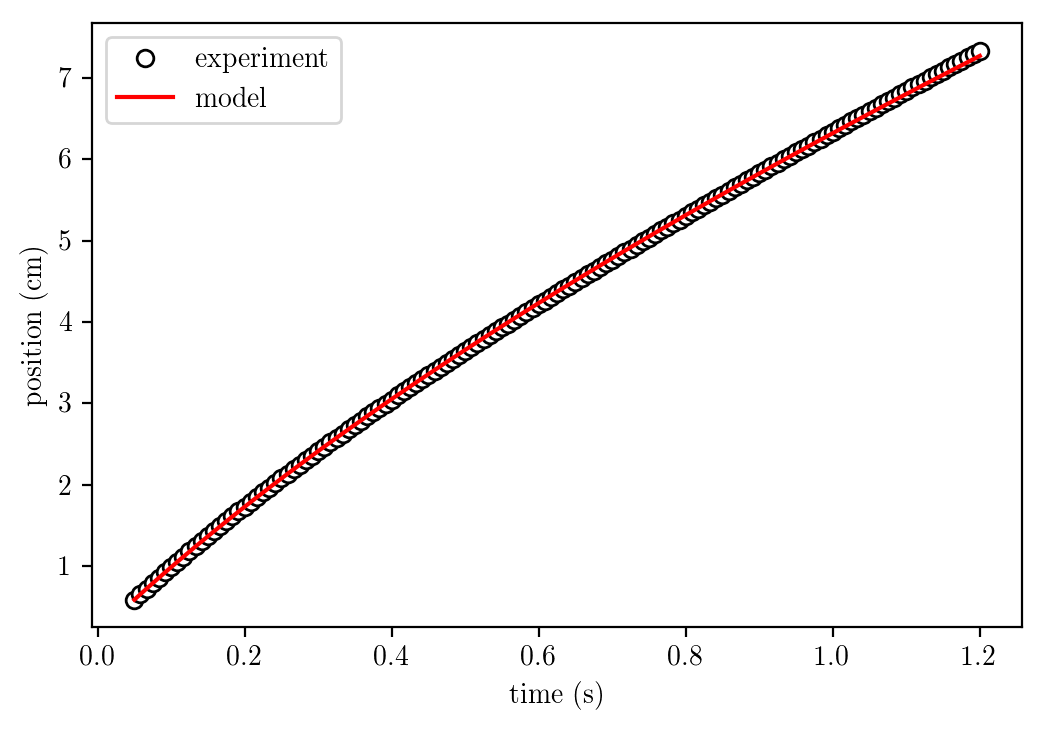

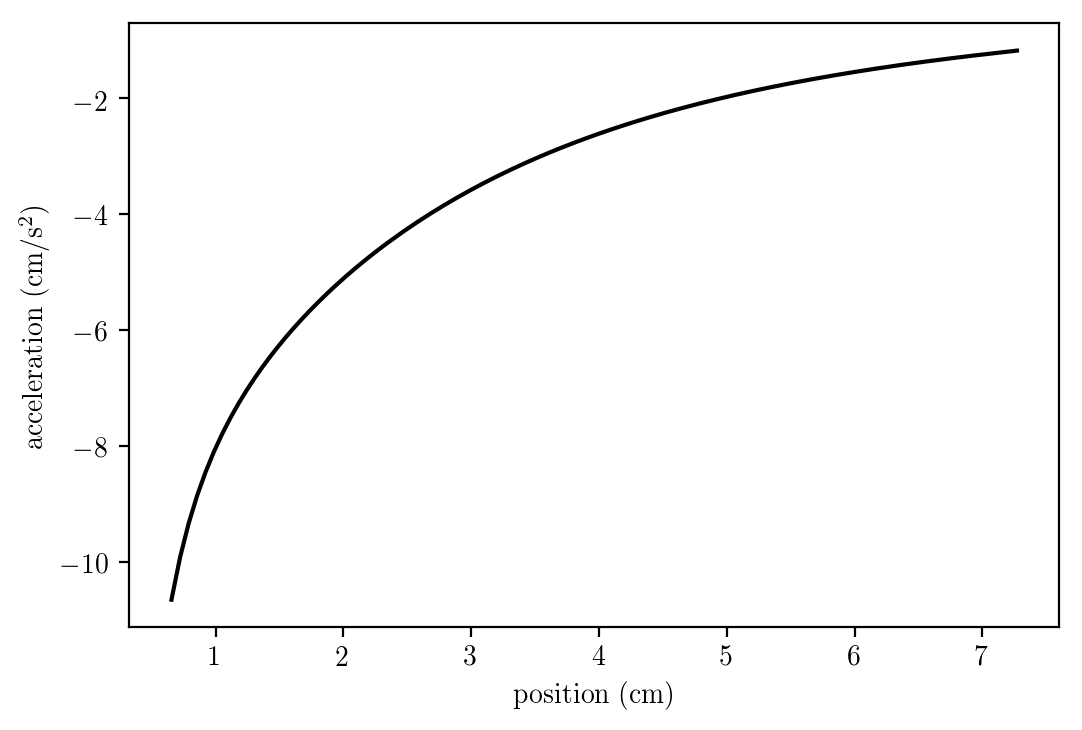

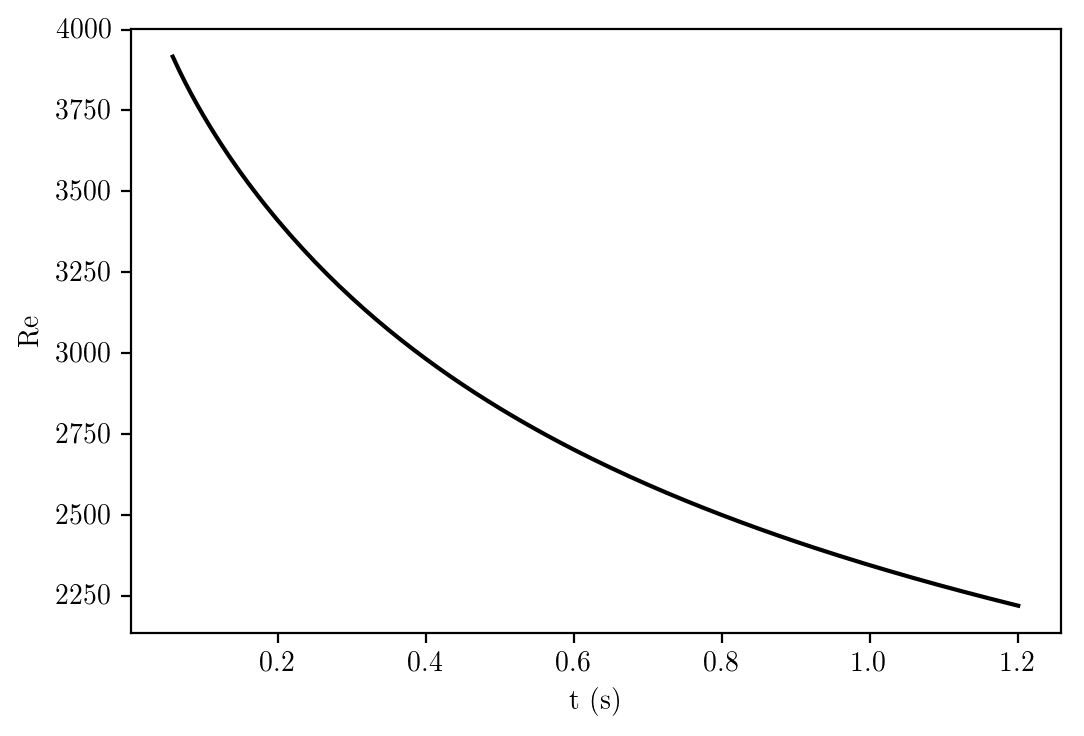

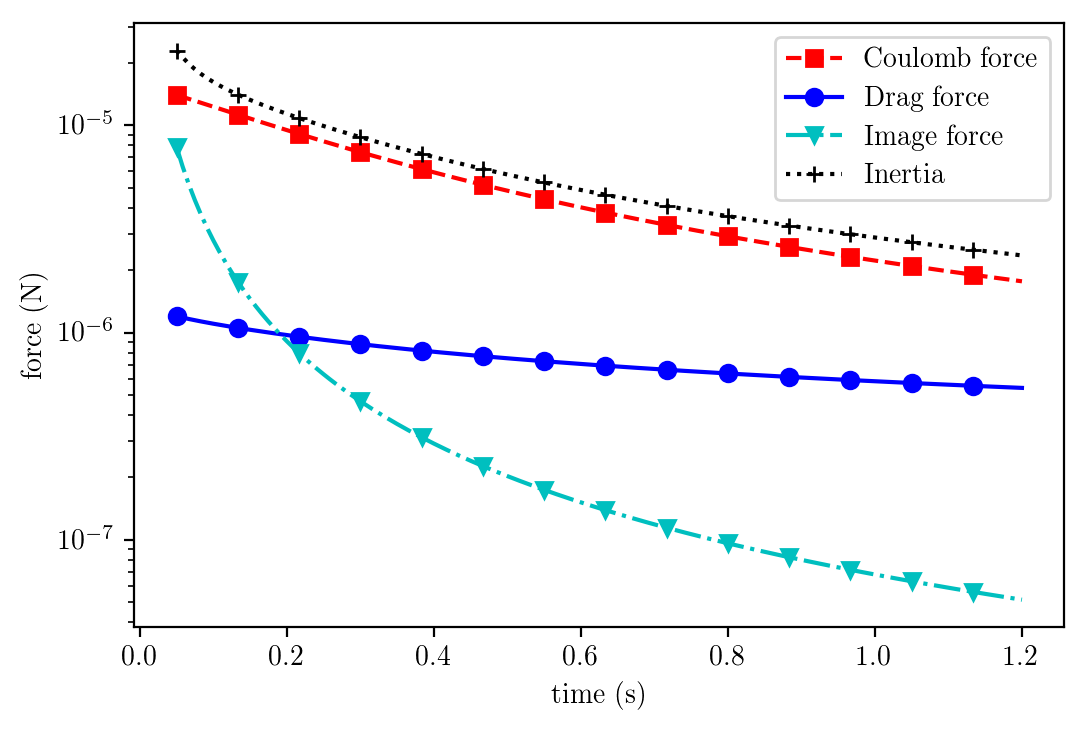

In [23]:
#%time
a=drop.guess*1 #= a #1.9*2.3
param_est_plot(drop, sub=False, method='nelder-mead', a=a, test=True) 

In [24]:
#drop.guess = a

In [25]:
## #A bash program to write experiemental metadata.
#header = {'name':1,'start':2,'end':3,'volume':4,'surfaceV':5, \
#          'frame_rate':6,'outlier':7,'time':8,'debias':9,'first_frame':10, 'layers':11, 'guess':12}
#row = !grep -n "{drop.name[4:]}" ../data/dielectric_improved/meta.csv | cut -d , -f 1 | cut -d : -f 1
#row = int(row[0])
#col = header['guess']
#value = drop.guess

In [26]:
#%%bash -s "$row" "$col" "$value"
#awk -F ";" -v r=$1 -v c=$2 -v val=$3 'BEGIN{OFS=";"}; NR != r; NR == r {$c = val; print}' \
#../data/dielectric_improved/meta.csv > ../data/dielectric_improved/meta2.csv
#cp ../data/dielectric_improved/meta2.csv ../data/dielectric_improved/meta.csv
#rm ../data/dielectric_improved/meta2.csv
#cat ../data/dielectric_improved/meta.csv

### Series estimates

In [27]:
i = 0
a = 0.72*2.3 #2.2
for drop in alldrops:
    print(drop)
    alldrops[drop].result, alldrops[drop].sim, \
    alldrops[drop].fsim, alldrops[drop].error  = res(alldrops[drop], a=a)
    param_est_plot(alldrops[drop], sub=True, adding=True)
    i += 1

drop07294
drop07295
drop07296
drop07297
drop07298
drop07299
drop07300
drop07319
drop07325
drop07326
drop07327
drop07328
drop07329
drop07334
drop07335
drop07336


In [161]:
sorted_keys = [elements[1] for elements in \
                 sorted([[vals.y_soln.max(), keys] for keys, vals in alldrops.items()])]
sorted_vals = [alldrops[x] for x in sorted_keys]
sorted_drops = dict(zip(sorted_keys, sorted_vals))

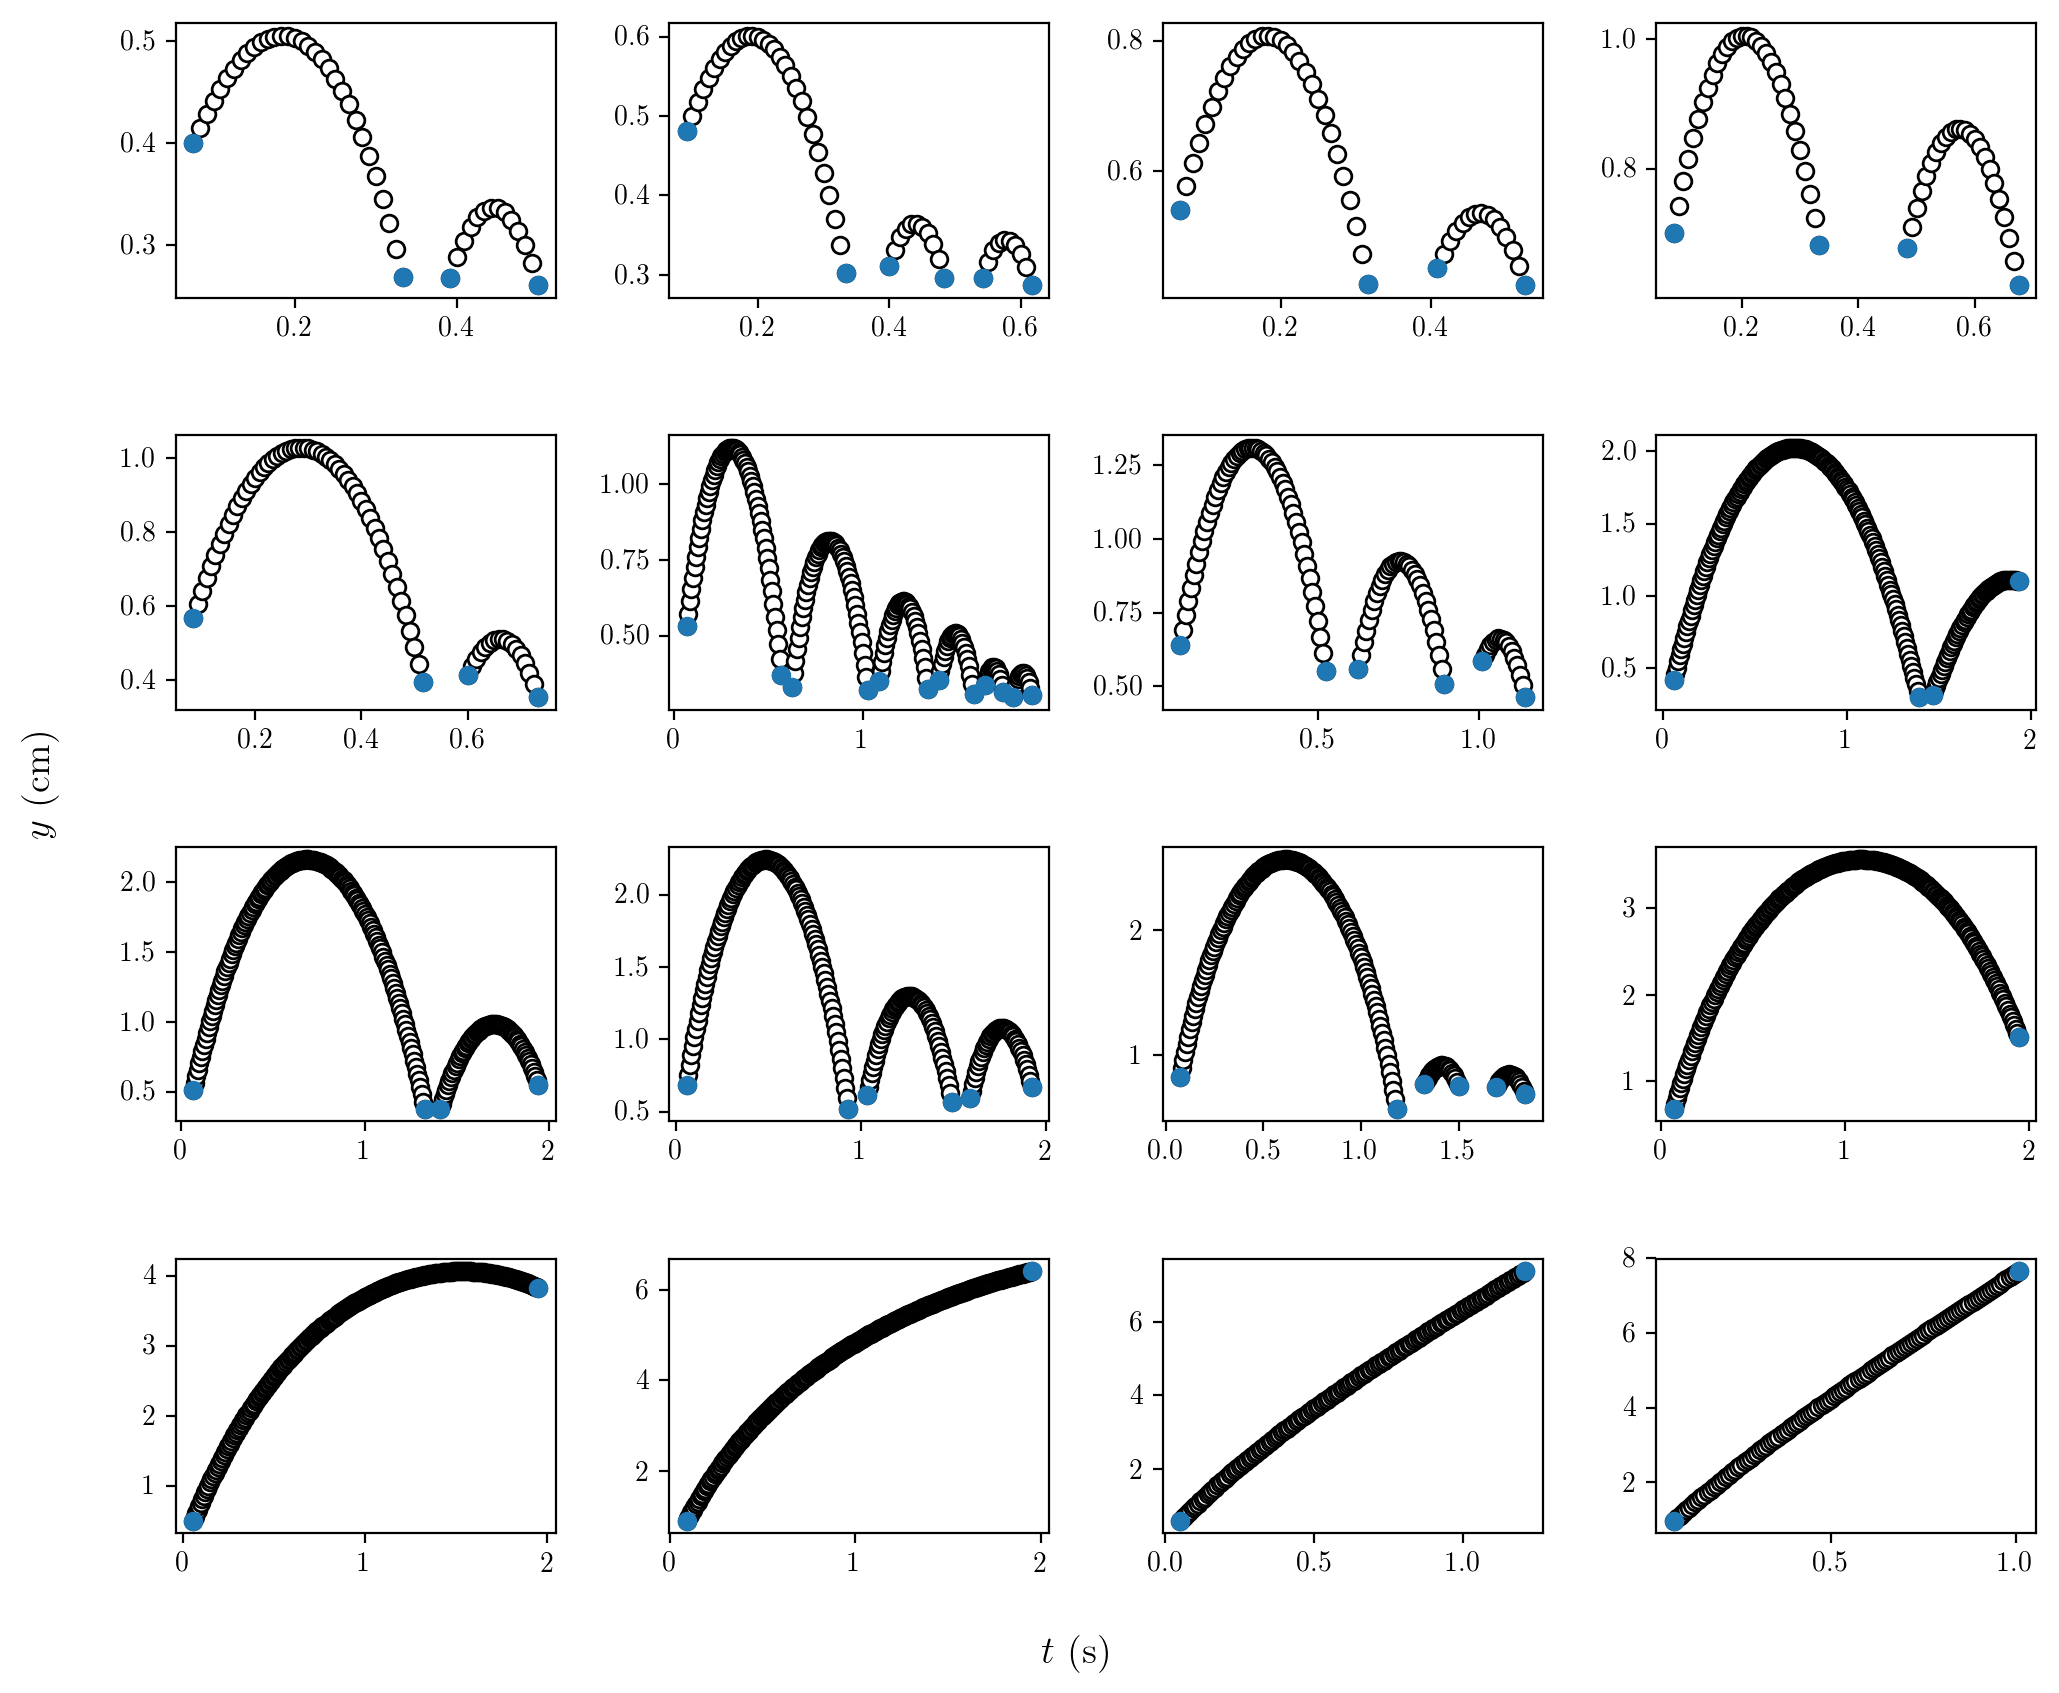

In [29]:
from math import ceil

fig, axs = plt.subplots(4,ceil(len(alldrops)/4), figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
i = 0
for drop in sorted_drops:
    plot_single(sorted_drops[drop], parted=True, variable='y_parted', sub=True, i=i, fig=fig, axs=axs)
    i += 1

fig.text(0.5, 0.06, r'$t$ (s)', ha='center', fontsize=14)
fig.text(0.06, 0.5, r'$y$ (cm)', va='center', rotation='vertical', fontsize=14)
#plt.legend(loc=(1.2, 2.55), borderaxespad=0., fontsize=14)
name = 'jump_matrix'
savefig(name, pics)
plt.show()

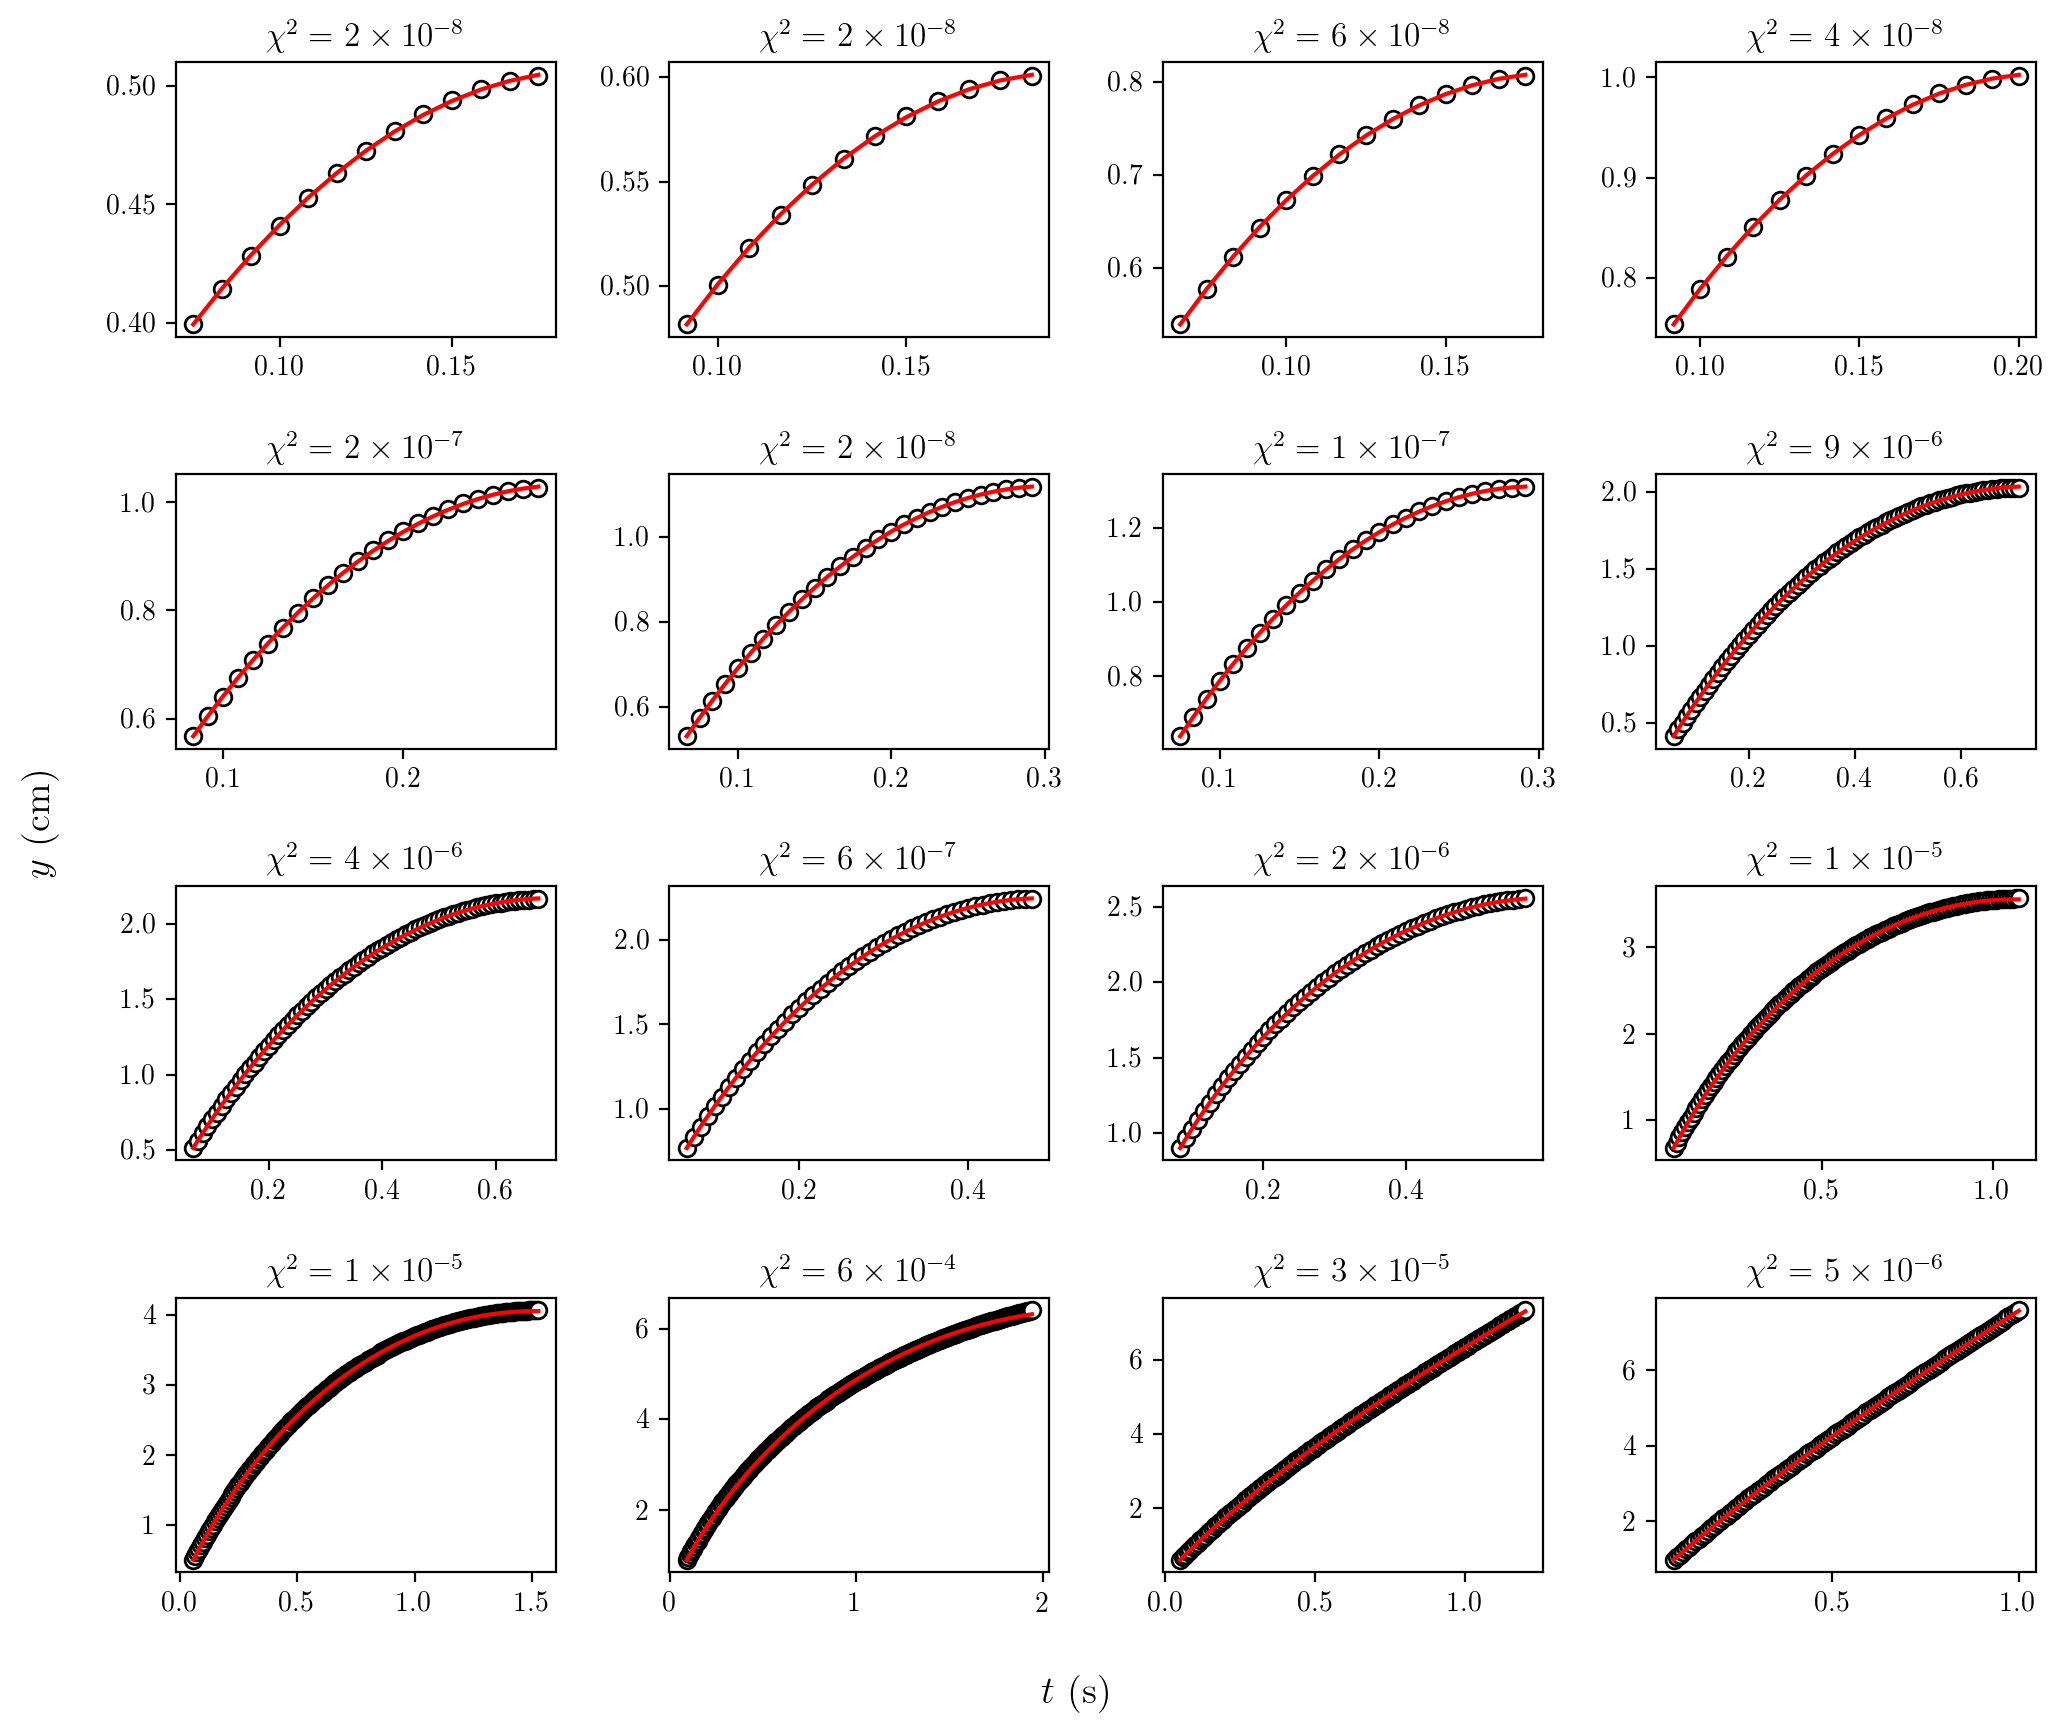

In [30]:
fig, axs = plt.subplots(4,ceil(len(alldrops)/4), figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
i = 0
for drop in sorted_drops:
    param_est_plot(sorted_drops[drop], sub=True, method='Nelder-Mead', a=a, i=i, fig=fig, axs=axs)
    i += 1

fig.text(0.5, 0.06, r'$t$ (s)', ha='center', fontsize=14)
fig.text(0.06, 0.5, r'$y$ (cm)', va='center', rotation='vertical', fontsize=14)
#plt.legend(loc=(1.2, 2.55), borderaxespad=0., fontsize=14)
name = 'inverse_problem'
savefig(name, pics)
plt.show()

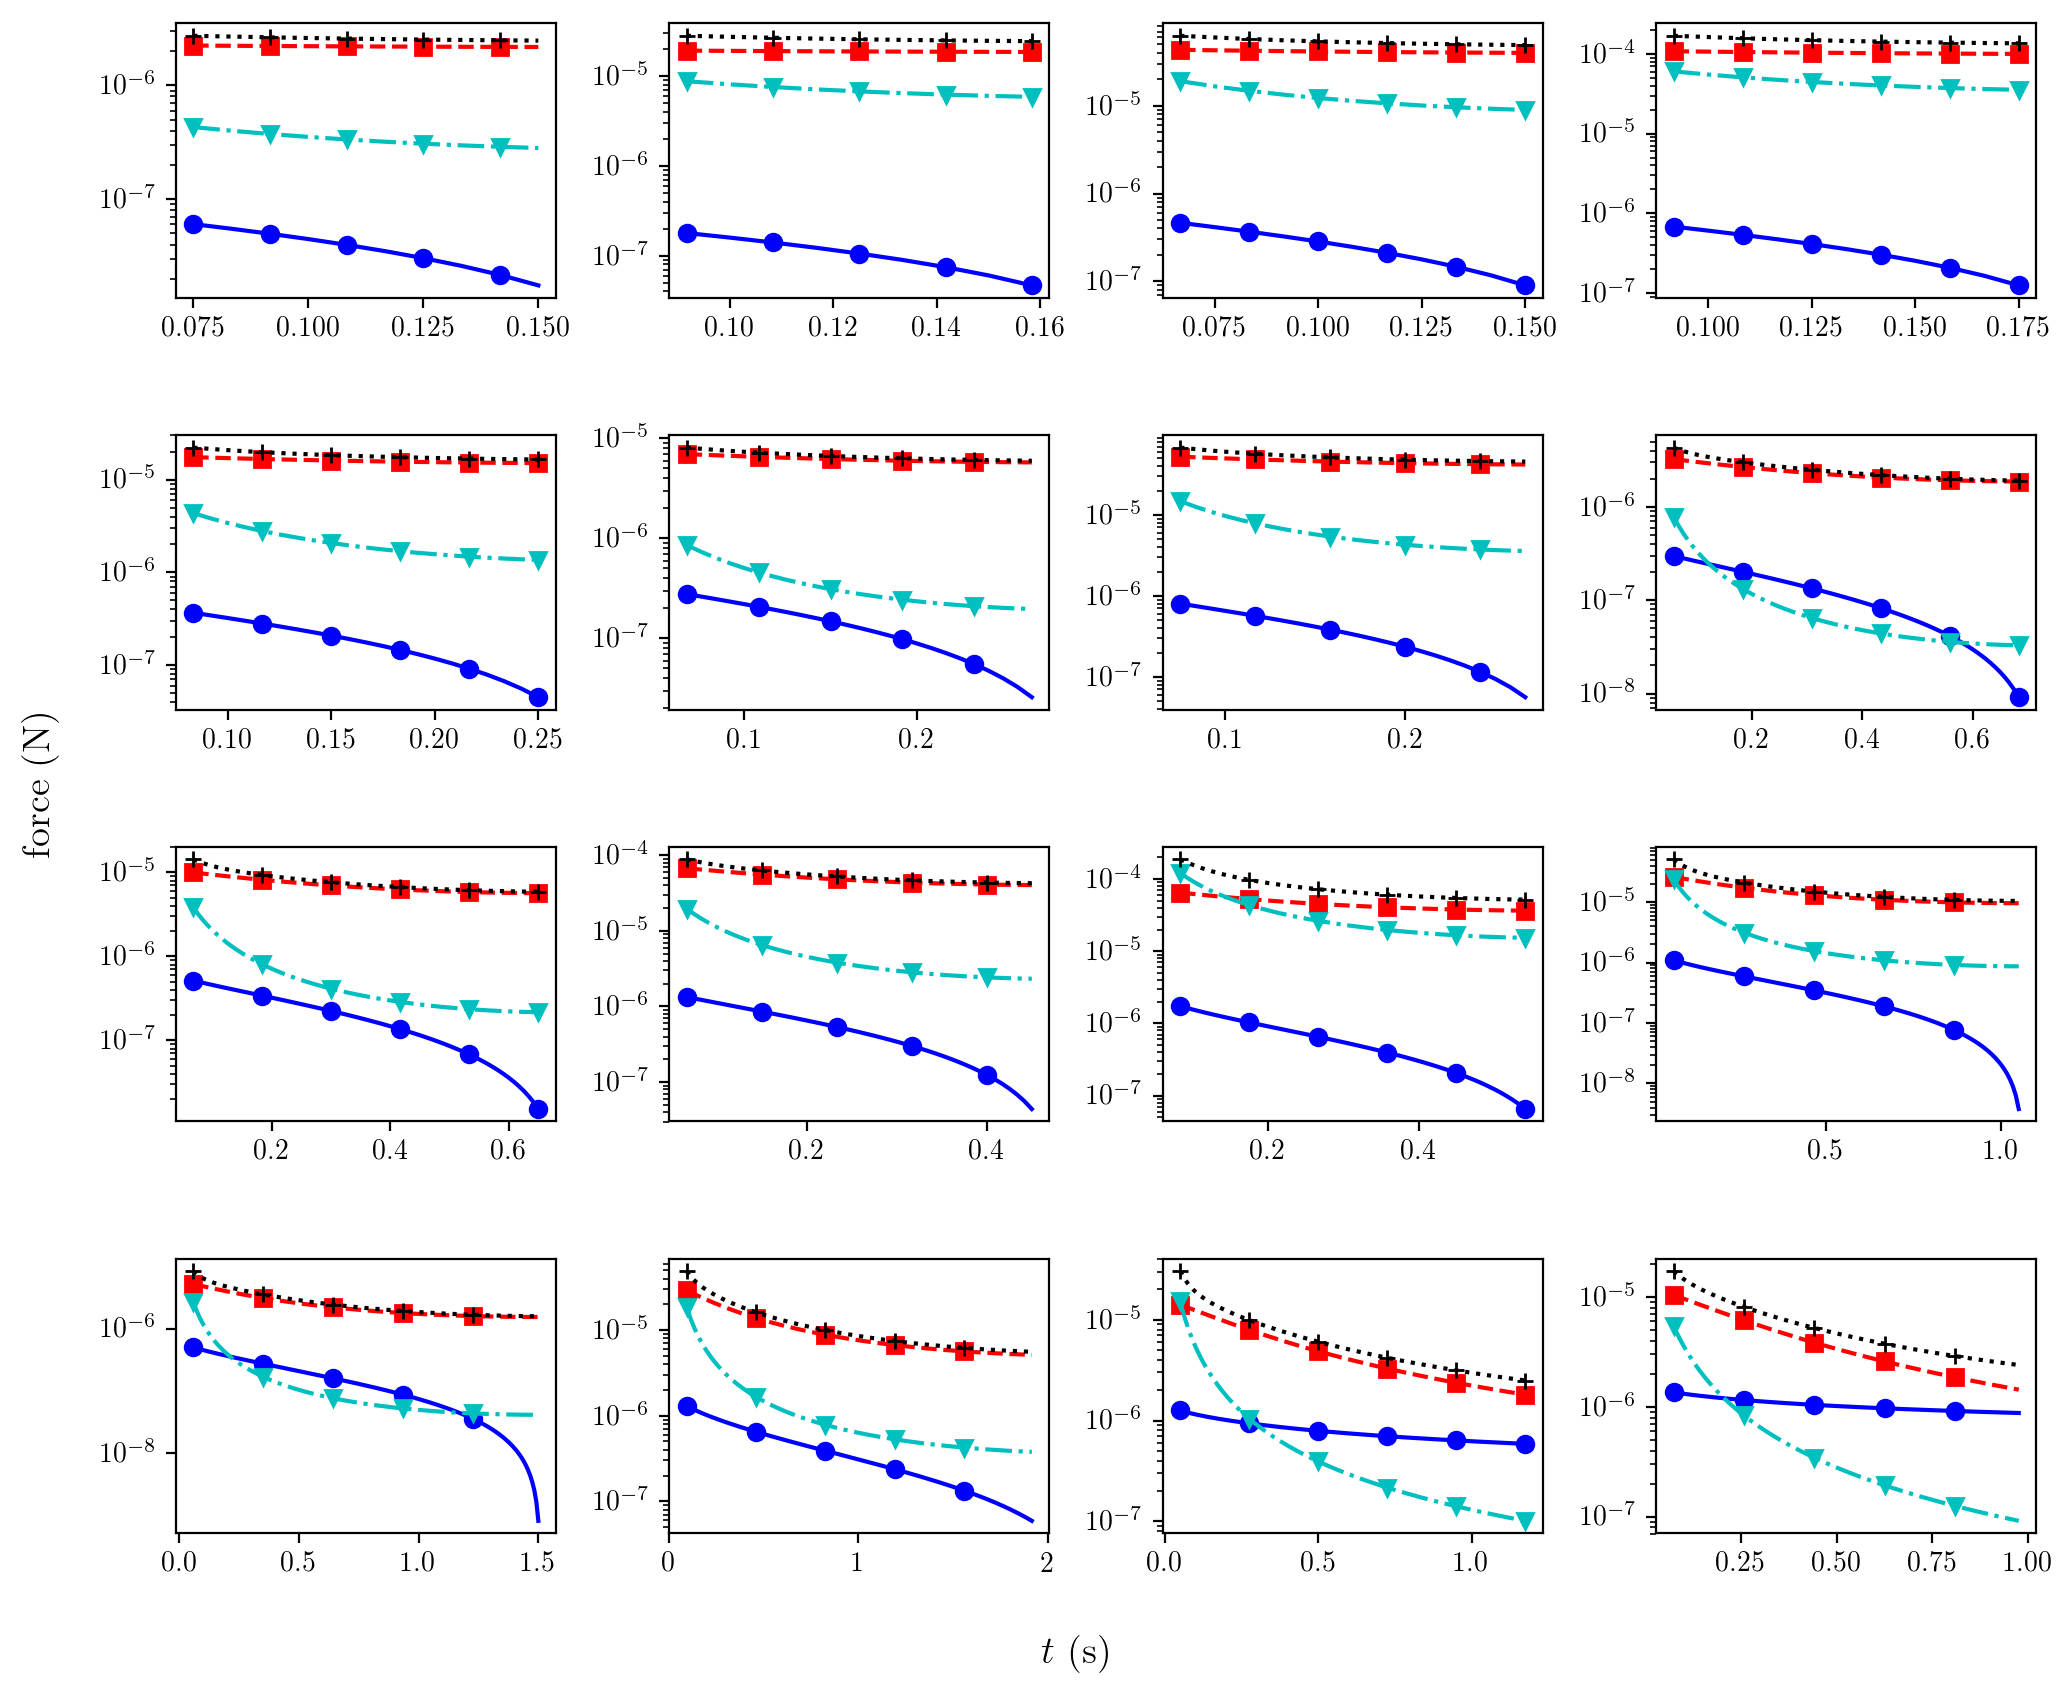

In [31]:
fig, axs = plt.subplots(4,ceil(len(alldrops)/4), figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
i = 0
for drop in sorted_drops:
    param_est_plot(sorted_drops[drop], sub=True, method='Nelder-Mead', forces=True, a=a, i=i, fig=fig, axs=axs)
    i += 1

fig.text(0.5, 0.06, r'$t$ (s)', ha='center', fontsize=14)
fig.text(0.06, 0.5, r'force (N)', va='center', rotation='vertical', fontsize=14)
#plt.legend(loc=(1.2, 2.45), borderaxespad=0., fontsize=14);
name = 'forces'
savefig(name, pics)
plt.show()

In [55]:
#likely outliers
outliers = {#'drop07294':alldrops.pop('drop07294'),
            'drop07334':alldrops.pop('drop07334')}
#alldrops['drop07334'] = outliers.pop('drop07334')def param_est(alldrops):
    #surfaceV, volume, q, dy0

KeyError: 'drop07334'

In [201]:
def param_est(alldrops):
    #surfaceV, volume, q, dy0
    Ef0 = []
    vols = []
    qs = []
    u0s = []
    surfaceVs = []
    for drop in alldrops.keys():
        qs.append(alldrops[drop].result.x[2])
        vols.append(alldrops[drop].result.x[1])
        y = get_data(alldrops[drop], param_est=True)[1]
        yStop = y[-1] + 20 * (y[-1]-y[-2])
        sigma = charge_density(alldrops[drop].result.x[0], alldrops[drop].layers)
        zf = np.linspace(1E-6, yStop, 10000)
        R_0 = radius(volume = alldrops[drop].result.x[1])
        Ef0.append(np.interp(radius(volume=alldrops[drop].result.x[1]), zf, electric_field(yStop, sigma)[0]))
        alldrops[drop].Ef0 = Ef0[-1]
        surfaceVs.append(alldrops[drop].result.x[0])
        u0s.append(alldrops[drop].result.x[3])
    return np.array(vols), np.array(qs), np.array(u0s), np.array(surfaceVs), np.array(Ef0)

vols, qs, u0s, surfaceVs, Ef0 = param_est(alldrops)

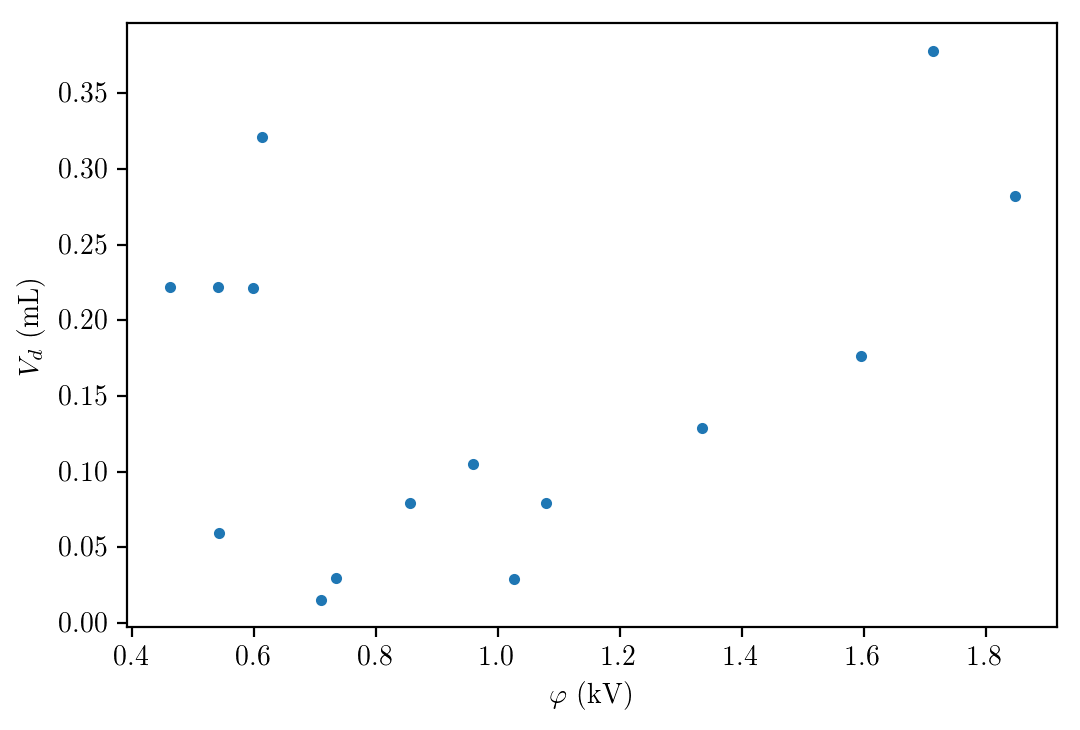

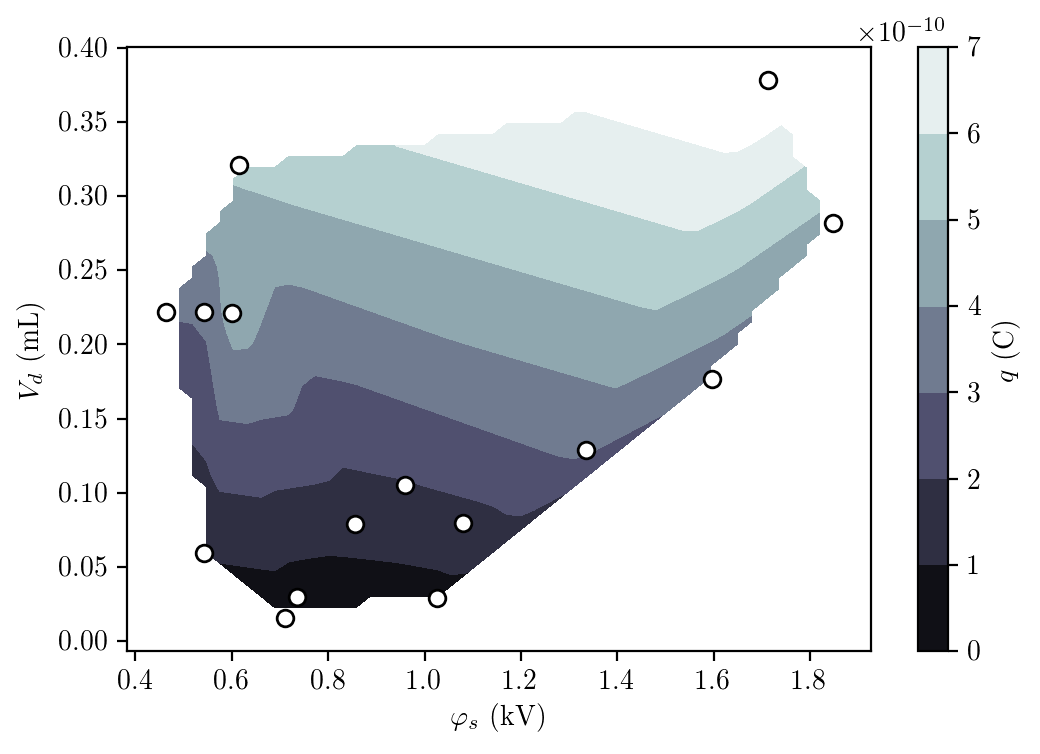

In [202]:
def drop_planning_plots(surfaceVs, vol, qs, **kwargs):
    x = np.array(surfaceVs)/1000
    y = vol
    z = qs
    plt.plot(x,y,'.')
    plt.xlabel(r'$\varphi$ (kV)')
    plt.ylabel('$V_d$ (mL)')
    plt.show()
    
    xi = np.linspace(min(x), max(x), 50)
    yi = np.linspace(min(y),max(y), 50)
    Z = matplotlib.mlab.griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)

    fig = plt.figure()
    #ax = Axes3D(fig)
    #ax.scatter(x, vols, qs, c='k', marker='o', s=40)

    #norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))
    #surf = ax.plot_surface(X,Y,Z, linewidth=1,
    #                       antialiased=True, cstride=2, 
    #                       rstride=2, edgecolor='k',
    #                       cmap=cm.jet, alpha=0.3, norm=norm)
    #fig.colorbar(surf, label=r'$q$ (C)')
    #ax.view_init(90, 35-90)
    CS = plt.contourf(X,Y,Z,cmap=plt.cm.bone)
    plt.scatter(x, y, color='k', facecolors='white', edgecolors='k')
    #CS2 = plt.contour(CS, levels=CS.levels[::2], colors='white')
    #fmt = matplotlib.ticker.LogFormatterMathtext()
    #fmt.create_dummy_axis()
    #manual_locations = [(-1, -1.4), (-0.62, -0.7), (-2, 0.5)]
    #plt.clabel(CS2, inline=1, colors='w', fontsize=10, fmt=fmt, manual=manual_locations)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('$q$ (C)')
    #cbar.add_lines(CS2)
    plt.xlabel(r'$\varphi_s$ (kV)')
    plt.ylabel(r'$V_d$ (mL)')
    #ax.set_xlabel(r'$E_0$ (kV/cm)')
    #ax.set_ylabel(r'Volume (mL)')
    #ax.set_zticks([])
    #ax.set_zlabel(r'$q$ (C)')
    if 'savefig' in kwargs.keys() and kwargs['savefig']==True:
        name = 'charge'
        savefig(name, pics)
    plt.show()
    
drop_planning_plots(surfaceVs, vols, qs, savefig=True)
#print(qs)

In [203]:
#from sympy import *
#init_printing()
#
#y, z, nu, a = symbols('y z nu a')
#nu*integrate(z/((z**2 + y**2)*sqrt(z**2 + y**2 + a**2/4)), (y,0,a/2))

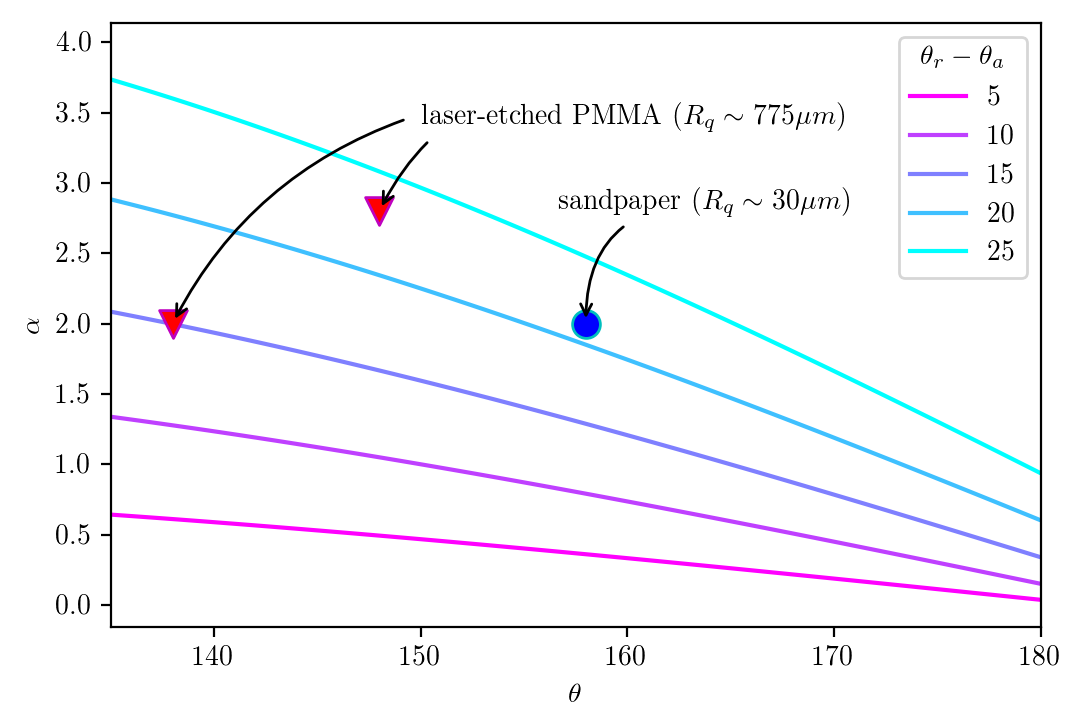

In [204]:
def hysteresis_plot():
    # relating apparent contact angle hysteresis to 
    # roll-off angle using the model of Furmidge, J. Colloid Sci. 1962, 17, 309.
    # 2 mL data for DDT surfaces

    #%config InlineBackend.figure_formats = ['svg']
    #matplotlib.rcParams['text.usetex'] = True
    #matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
    #matplotlib.rcParams['text.latex.unicode'] = True
    #matplotlib.rcParams.update(pgf_with_latex)
    n = np.linspace(5,25,5)
    a = np.linspace(130,180,100)
    const = -10
    colors = plt.cm.cool_r(np.linspace(0,1,len(n)))

    for k,i in np.ndenumerate(n):
        b = a - i
        hyster = np.arcsin(np.cos(a*np.pi/180)-np.cos(b*np.pi/180))
        plt.plot(a, const*hyster, label=int(i), color=colors[k], zorder=1)

    exp_roll_off = 2.8
    exp_CA_appar = 148
    plt.scatter([exp_CA_appar,138],[exp_roll_off,2],100, marker="v", facecolors='r', edgecolors='m', zorder=2)
    plt.annotate('laser-etched PMMA ($R_q \sim 775 \mu m$)', xy=(exp_CA_appar,exp_roll_off), xycoords='data', 
                xytext=(15, 30), textcoords='offset points', fontsize=10, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.47"))
    plt.annotate('', xy=(138,2), xycoords='data', 
                xytext=(85,74), textcoords='offset points', fontsize=10, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))

    plt.scatter([158,],[2,],100, marker="o", facecolors='b', edgecolors='c', zorder=2)
    plt.annotate('sandpaper ($R_q \sim 30 \mu m$)', xy=(158,2), xycoords='data', 
                xytext=(-10, 40), textcoords='offset points', fontsize=10, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.5"))

    plt.legend(title=r'$\theta_r - \theta_a$', loc='upper right')
    axes = plt.gca()
    axes.set_xlim(135,180)
    plt.xticks([140,150, 160,170, 180])
    plt.ylabel(r'$\alpha$')
    plt.xlabel(r'$\theta$')
    name = 'hysteresis'
    savefig(name, pics)
    plt.show()

hysteresis_plot()

In [230]:
def impact_data(drop):
    """
    Returns Weber numbers, contact times, and coefficients of restituion for each bounce event in a drop.
    """
    ym, t, dt, contact_mask, y_parted, dy_parted, ddy_parted, t_parted, ind_parted = get_data(drop, param_est=False)
    ind_parted = ind_parted[1:-1]
    impact_weber = weber(drop, dy_parted[ind_parted])[::2]
    ind_parted = ind_parted.tolist()
    contact_time = np.array([])
    diameter_ratio = np.array([])
    restitution = np.array([])
    for keys, vals in enumerate(ind_parted[::2]):
        ind_parted.index(ind_parted[::2][keys])
        pair = [ind_parted[::2][keys], ind_parted[ind_parted.index(ind_parted[::2][keys])+1]]
        contact_time = np.append(contact_time, t_parted[pair[1]]-t_parted[pair[0]])
        restitution = np.append(restitution, abs(dy_parted[pair[1]]/dy_parted[pair[0]]))
        
        # Note: I scale the contact time by a parameter such that it 
        # gives the same results as a manual count of frames.
    try:
        tb = t_parted[ind_parted[0]]
    except IndexError:
        tb = False
    return impact_weber, contact_time*.78, diameter_ratio, restitution*.78, tb #0.78

def q_to_m(drop):
    #surfaceV, volume, q, dy0
    density = 1000
    U = drop.dy_soln[0]/100 #drop.result.x[3]
    old_inertia = density * 2 * radius(volume=drop.result.x[1])**2 * U**2
    old_e_force = charge_density(drop.result.x[0], drop.layers)*eta_0*drop.result.x[2]
    #e_force = drop.result.x[0]/2.54*100*drop.result.x[2]
    e_force = drop.Ef0*drop.result.x[2]
    inertia = mass(drop.result.x[1]) * U**2
    eu_s = inertia/(e_force*radius(volume=drop.result.x[1]))
    eu_l = eu_s * 2 * np.pi *radius(volume=drop.result.x[1])**2/d**2
    return eu_s, eu_l

def img(drop):
    q = drop.result.x[2]
    rad = radius(volume=drop.result.x[1])
    eta_a=eta_r
    susceptibility = eta_a - 1
    k = susceptibility/(susceptibility+2)
    return k * q /(16*np.pi*eta_0*rad**2*drop.Ef0)
    
def tc(drop):
    eps = q_to_m(drop)[0]
    tc_s = eps*radius(volume=drop.result.x[1])/(drop.result.x[3])
    tc_l = 1/q_to_m(drop)[1]*radius(volume=drop.result.x[1])/(drop.result.x[3])
    tfl = 2 + 1.333*q_to_m(drop)[1] + 0.799*q_to_m(drop)[1]**2
    tfs = (-4*eps**2*(0.0121*eps + 0.2121)*(2*(0.0121*eps + 0.2121)**4 + 
        6*(0.0121*eps + 0.2121)**3 - 4*(0.0121*eps + 0.2121)**2 + 1)/
    (0.363*eps + 40*(0.0121*eps + 0.2121)**3 + 60*(0.0121*eps + 0.2121)**2 + 11.363) 
    + 4*eps*(-0.0121*eps + 0.7879)*(0.0121*eps + 0.2121)/(3*(0.0242*eps + 1.4242)) + 2)
    return tc_s, tc_l, tfl, tfs

def yc(drop):
    yc_s = q_to_m(drop)[0]*radius(volume=drop.result.x[1])
    yc_l = 1/q_to_m(drop)[1]*radius(volume=drop.result.x[1])
    return yc_s, yc_l

def impact_plots(alldrops):
    #fig1, ax1 = plt.subplots()
    qm = np.array([])
    i_weber = np.array([])
    contact_r = np.array([])
    restn = np.array([])
    oh = np.array([])
    bo = np.array([])
    
    for keys in alldrops:
        impact_weber, contact_time, diameter_ratio, restitution, tb = impact_data(alldrops[keys])
        if impact_weber.size != 0:
                    qm = np.append(qm, impact_weber.size*[q_to_m(alldrops[keys])[0]])
                    R_drop = radius(volume=alldrops[keys].result.x[1])
                    oh = np.append(oh, impact_weber.size*[ohnesorge(alldrops[keys])])
                    bo = np.append(bo, impact_weber.size*[bond(alldrops[keys])])
        i_weber = np.append(i_weber, impact_weber)
        restn = np.append(restn, restitution)
        contact_r = np.append(contact_r, contact_time/tj(alldrops[keys]))
        alldrops[keys].tb = tb
        print(keys, restitution)
    
    fig = plt.figure()
    norm = matplotlib.colors.Normalize(vmin=bo.min(), vmax=bo.max())
    cmap = plt.cm.rainbow
    plt.scatter(i_weber, contact_r, c=bo, cmap=cmap, norm=norm)
    cb1 = plt.colorbar()
    cb1.set_label(r'$\mathrm{\mathit{Bo_e}} \equiv \frac{\epsilon E_0^2 R_0}{\gamma}$')
    
    plt.xscale('log')
    plt.xticks([10**(-2),10**(-1),10**0])
    #plt.grid(which='both', linestyle='--')
    plt.plot(np.linspace(10**(-2),10**0, 100), 2.2*np.ones(100), label='Richards 2001')
    plt.legend(loc=2)
    plt.xlabel('$We$')
    plt.ylabel(r'$t_j/ \tau$')
    name = 'contact'
    savefig(name, pics)
    plt.show()
   
    fig = plt.figure()
    plt.scatter(i_weber, restn, c=bo, cmap=plt.cm.rainbow, norm=norm)
    plt.xscale('log')
    plt.xticks([10**(-2),10**(-1),10**0])
    #plt.grid(which='both', linestyle='--')
    cb2 = plt.colorbar()
    cb2.set_label(r'$\mathrm{\mathit{Bo_e}} \equiv \frac{\epsilon E_0^2 R_0}{\gamma}$')
    plt.xlabel('$We$')
    plt.ylabel('$C_r$')
    name = 'restitution'
    savefig(name, pics)
    plt.show()

drop07294 [ 0.64030092]
drop07295 []
drop07296 []
drop07297 [ 0.54395677]
drop07298 []
drop07299 [ 0.53198451]
drop07300 [ 0.59182721]
drop07319 [ 0.55354135  0.67648944]
drop07325 [ 0.61341148  0.35076624]
drop07326 [ 0.3936598]
drop07327 []
drop07328 [ 0.40307404]
drop07329 [ 0.48576237  0.69442293]
drop07335 []
drop07336 [ 0.68137044  0.61123356  0.59528561  0.46463839  0.77489371]


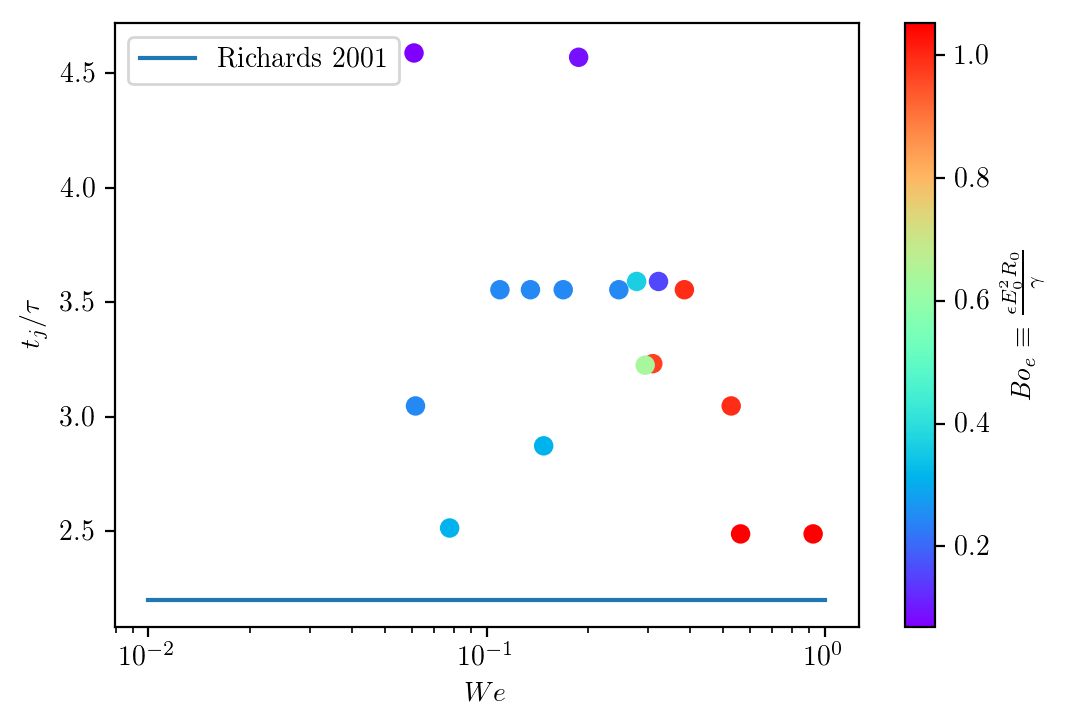

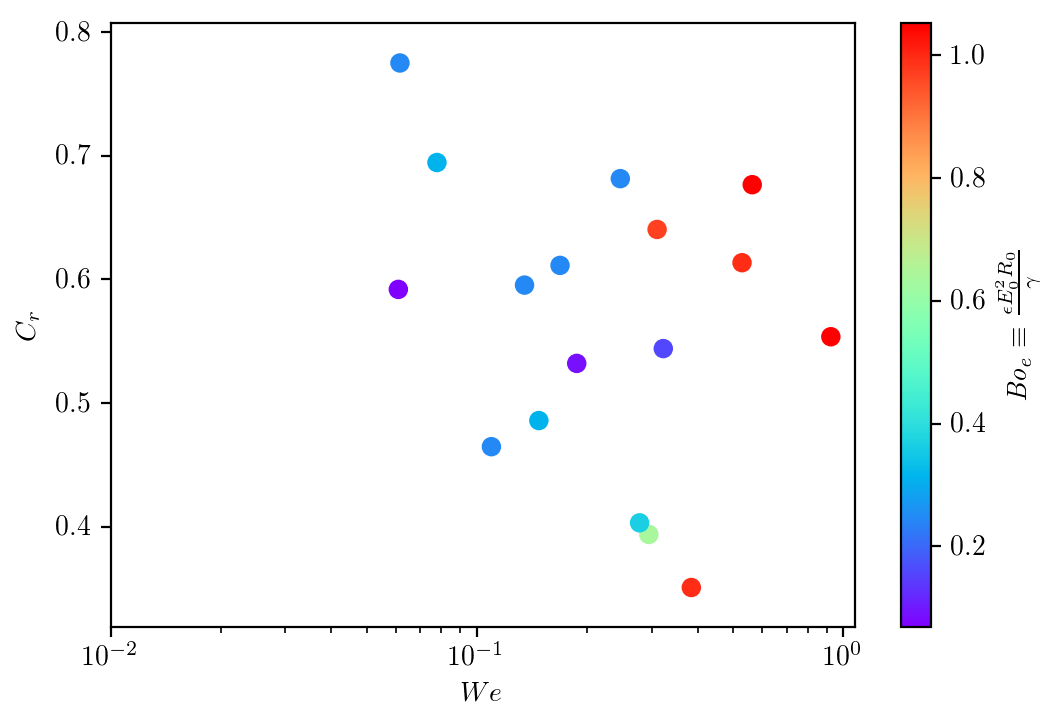

In [231]:
impact_plots(alldrops)

In [207]:
figure_series = {'drop07296':drop07296, 'drop07327':drop07327, 'drop07295':drop07295,
                 'drop07335':drop07335, 'drop07319':drop07319, 'drop07300':drop07300,
                 'drop07325':drop07325, 'drop07326':drop07326}

In [208]:
sorted_keys = [elements[1] for elements in \
                 sorted([[q_to_m(vals), keys] for keys, vals in alldrops.items()])]


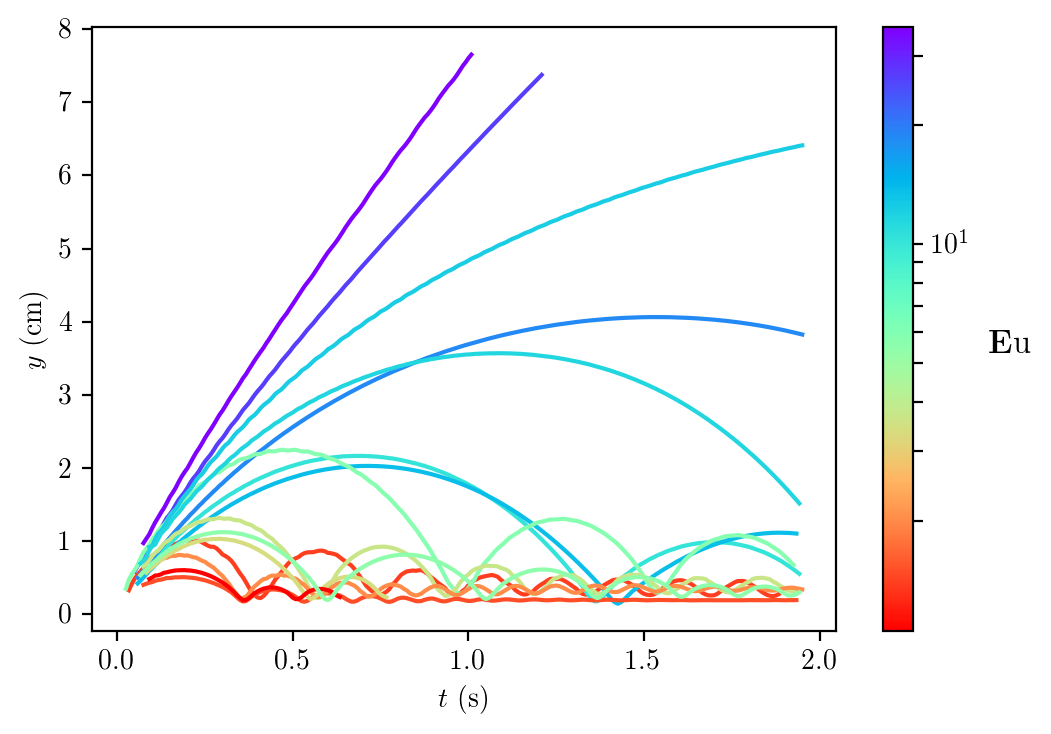

In [221]:
col = 'rainbow_r'

m=-5
sorted_vals = [alldrops[x] for x in sorted_keys[:m]]
sorted_drops = dict(zip(sorted_keys, sorted_vals))
plot_series(alldrops, component='YM', qm=True, label=[r'$t$ (s)', r'$y$ (cm)'], col=col)
#plot_series(figure_series, component='YM', qm=True, label=[r'$t$ (s)', r'$y$ (cm)'], 
#            savefig=True, reg = 's', name='series_s_eu', col=col)

#n= 0
#m=-1
#sorted_vals = [alldrops[x] for x in sorted_keys[n:m]]
#sorted_drops = dict(zip(sorted_keys, sorted_vals))
#plot_series(sorted_drops, component='YM', qm=True, label=[r'$\bar{t}$', r'$\bar{y}$'], 
#            savefig=True, reg = 'll', dimless = True, name='series_s_ds_ll', col=col)

#
#n = -5
#sorted_vals = [alldrops[x] for x in sorted_keys[n:]]
#sorted_drops = dict(zip(sorted_keys, sorted_vals))
#plot_series(sorted_drops, component='YM', qm=True, label=[r'$\bar{t}$',r'$\bar{y}$'], 
#            savefig=True, reg = 'l', dimless = True, name='series_l_ds', col=col)
#

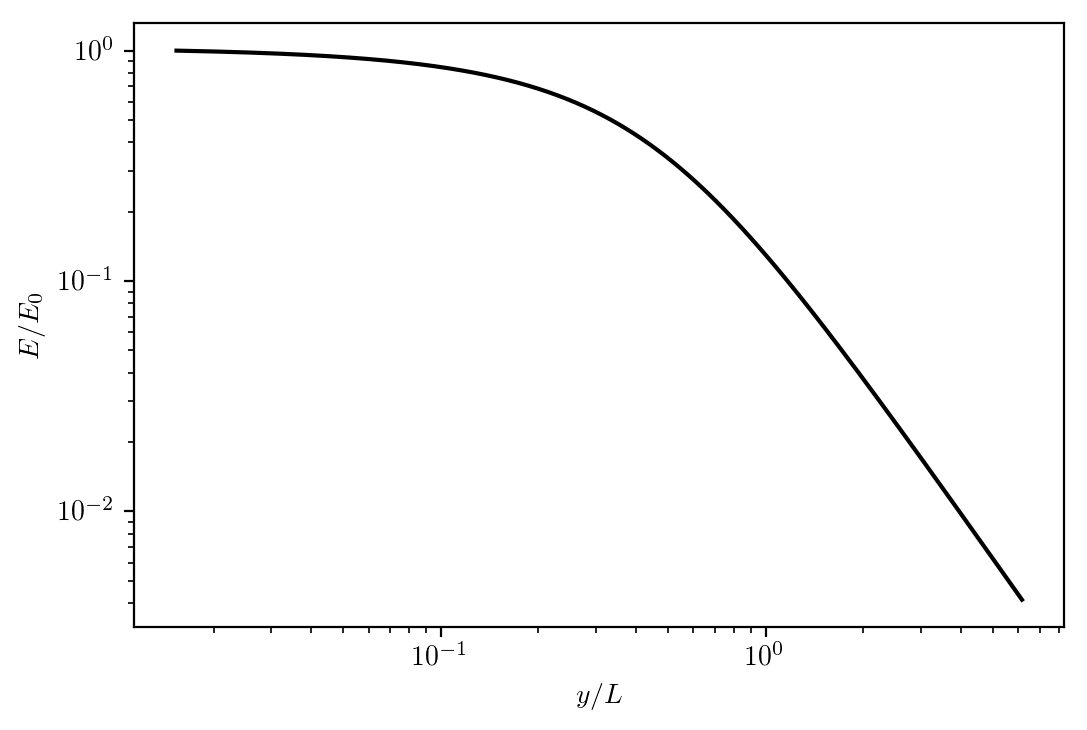

In [42]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

#print(650*eta_0/(2.54/100), 'field meter')
#print(650*eta_0/(2.54/100), 'non-contacting voltmeter')
#print(650*eta_0*3/(0.4*5/1000), 'nc-voltmeter w/ dielectric back by conductive groundplane')

drop = drop07298

ef = electric_field(40/100, charge_density(drop.result.x[0], drop.layers))[0]
z = np.linspace(1/1000, 40/100, 10000)

E0 = charge_density(drop.result.x[0], drop.layers)/(2*eta_0)
plt.loglog(z/(6.5/100), ef/E0, 'k')
plt.ylabel(r'$E/E_0$')
plt.xlabel(r'$y/L$')

name = 'E0'
savefig(name, pics)
plt.show()

#print(np.interp(2.54/100,z,ef)/1000, 'electric field at 2.54 cm')

In [43]:
#for drop in sorted_drops:
#    print(drop)
#    check_design_feasibility(sorted_drops[drop], sorted_drops[drop].result)
#    print('\n')

                    Robust linear Model Regression Results                    
Dep. Variable:                 charge   No. Observations:                   15
Model:                            RLM   Df Residuals:                       11
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 24 Jan 2018                                         
Time:                        16:16:28                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.853e-12   1.05e-10      0.084      0.9

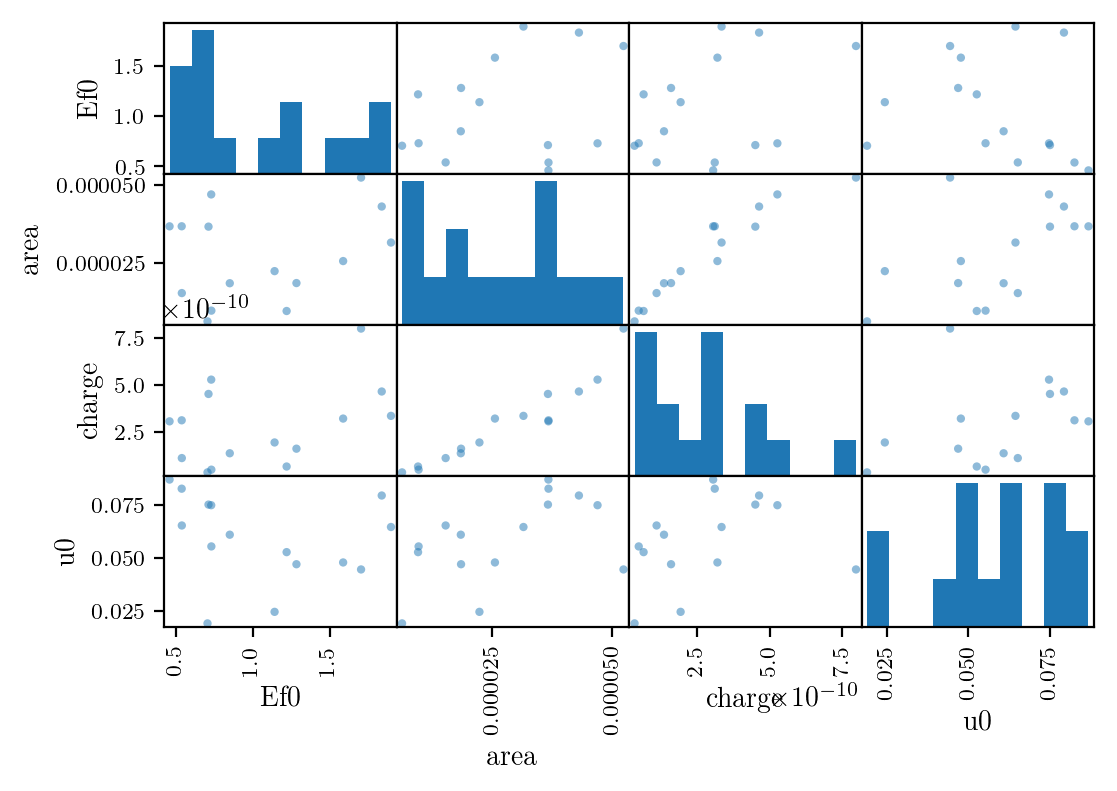

In [44]:
import pandas
from statsmodels.formula.api import ols, rlm, WLS
from pandas import plotting
import seaborn

def scatter_matrix(x):
    area, qs, u0s, surfaceVs, Ef0 = x
    data = pandas.DataFrame({'area':area, 'charge':qs, 'u0': u0s, 'Ef0':Ef0/100/1000})
    plotting.scatter_matrix(data);
    data = pandas.DataFrame({'area':area, 'charge':qs, 'u0': u0s, 'Ef0':Ef0})
    #model = ols('charge ~  area * surfaceV', data)
    model = rlm('charge ~  area * Ef0', data)
    r2_wls = WLS(model.endog, model.exog, weights=model.fit().weights).fit().rsquared
    print(model.fit().summary())
    print(r'R^2 = {}'.format(r2_wls))

area = (vols/1E6)**(2/3)
variables = (area, qs, u0s, surfaceVs, Ef0)
scatter_matrix(variables)
name = 'scatter'
savefig(name, pics)
plt.show()

In [45]:
parallel = np.abs(np.array([ -2.70158796e-12,  -4.20176010e-12,   7.78928795e-12,  -4.86568450e-12,
  -1.79171842e-12,  -1.74111697e-11,  -1.07898239e-11,  -5.68331113e-12,
  -2.89082418e-12,  -2.57343722e-12,  -1.30402067e-11,  -7.51379045e-13,
   1.11525974e-12,  -9.83808965e-13,  -6.00145897e-13,  -2.84923705e-12,
  -9.78463511e-12]))
stats.ttest_ind(qs, parallel, equal_var=False)

Ttest_indResult(statistic=5.1139524779704342, pvalue=0.00015713136500429979)

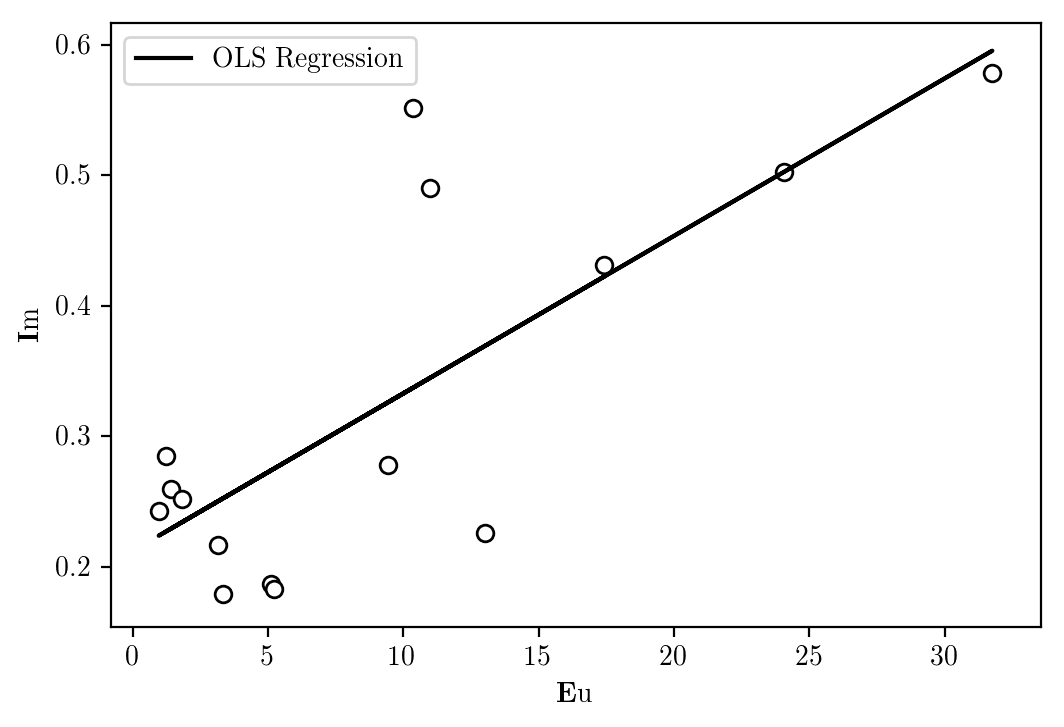

In [139]:
from statsmodels.stats.anova import anova_lm
ims = np.array([])
eus = np.array([])
plt.figure()
for drop in alldrops:
    eus = np.append(eus, q_to_m(alldrops[drop])[0])
    ims = np.append(ims, img(alldrops[drop]))

# Convert the data into a Pandas DataFrame to use the formulas framework
# in statsmodels
data = pandas.DataFrame({'Eu': eus, 'Im': ims})

# Fit the model
model = ols(formula="Im ~ Eu", data=data).fit()
offset, coef = model._results.params
plt.plot(eus, eus*coef + offset, 'k-', label='OLS Regression')
plt.scatter(eus, ims, color='w', edgecolors='k')

plt.xlabel(r'$\mathbf{E}\mbox{u}$')
plt.ylabel(r'$\mathbf{I}\mbox{m}$')
plt.legend()
name = 'dnumbs'
savefig(name, pics)
plt.show()

In [140]:
# Print the summary
print(model.summary())

# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)


                            OLS Regression Results                            
Dep. Variable:                     Im   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     18.76
Date:                Wed, 24 Jan 2018   Prob (F-statistic):           0.000815
Time:                        19:03:59   Log-Likelihood:                 15.067
No. Observations:                  15   AIC:                            -26.13
Df Residuals:                      13   BIC:                            -24.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2121      0.036      5.941      0.0

/home/erin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/home/erin/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/erin/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/erin/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


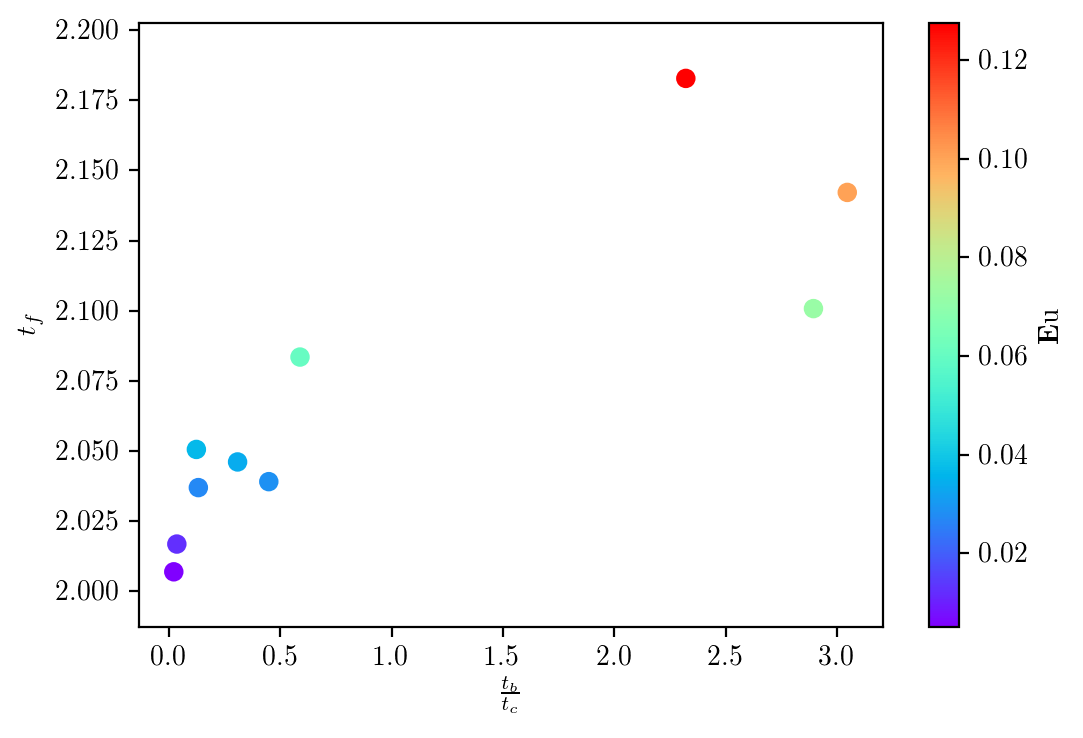

In [157]:
sorted_keys = [elements[1] for elements in \
                 sorted([[vals.y_soln.max(), keys] for keys, vals in alldrops.items()])]
m=-5
sorted_vals = [alldrops[x] for x in sorted_keys[:m]]
sorted_drops = dict(zip(sorted_keys, sorted_vals))

bo = np.array([q_to_m(alldrops[x])[1] for x in sorted_keys[:m]])
norm = matplotlib.colors.Normalize(vmin=bo.min(), vmax=bo.max())
cmap = plt.cm.rainbow
tbl = np.array([])
tcl = np.array([])
for drop in sorted_drops:
    #print(2*sorted_drops[drop].tb/tc(sorted_drops[drop])[3])
    tbl = np.append(tbl, sorted_drops[drop].tb/tc(sorted_drops[drop])[1])
    tcl = np.append(tcl, tc(sorted_drops[drop])[2])
plt.scatter(tbl, tcl, c=bo, cmap=cmap, norm=norm)
cb1 = plt.colorbar()
cb1.set_label(r'$\mathbf{E}\mbox{u}$')
plt.xlabel(r'$\frac{t_b}{t_c}$')
plt.ylabel(r'$t_f$')
name = 'times'
savefig(name, pics)
plt.show()

In [223]:
#m = -1
#sorted_vals = [alldrops[x] for x in sorted_keys[:m]]
#sorted_drops = dict(zip(sorted_keys, sorted_vals))
#
#bo = np.array([q_to_m(alldrops[x])[0] for x in sorted_keys[:m]])
#norm = matplotlib.colors.Normalize(vmin=bo.min(), vmax=bo.max())
#cmap = plt.cm.rainbow
#
#tbs = np.array([])
#tcs = np.array([])
#for drop in sorted_drops:
#    tbs = np.append(tbs, sorted_drops[drop].tb/tc(sorted_drops[drop])[0])
#    tcs = np.append(tcs, tc(sorted_drops[drop])[3])
#
#plt.scatter(tbs, tcs, c=bo, cmap=cmap, norm=norm)
#cb1 = plt.colorbar()
#cb1.set_label(r'$\mathbf{E}\mbox{u}$')
#plt.xlabel(r'$\frac{t_b}{t_c}$')
#plt.ylabel(r'$t_f$')
#plt.ylim(ymin=1.9, ymax=2.2)
#plt.xlim(xmin = 2.5, xmax=3)
#name = 'times_short'
#savefig(name, pics)
#plt.show()